# CMIP6 Temperature Changes

Description: The goal is to build a data structure of temperature changes across the model ensemble. We will build one for global time-series and one for spatially-resolved trends.

# Preprocessing Data

In [62]:
#imports
from matplotlib import pyplot as plt
from scipy import stats
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs

In [63]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

activity_id institution_id     source_id       experiment_id member_id  \
0  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   
1  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   
2  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   
3  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   
4  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   

  table_id variable_id grid_label  \
0     Amon          ps         gn   
1     Amon        rsds         gn   
2     Amon        rlus         gn   
3     Amon        rlds         gn   
4     Amon         psl         gn   

                                              zstore  dcpp_init_year   version  
0  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706  
1  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706  
2  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706  
3  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706  
4  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706

In [64]:
gcs = gcsfs.GCSFileSystem(token='anon')

In [65]:
df_tas_hist=df.query  ("activity_id=='CMIP'         & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'& member_id=='r1i1p1f1'")
df_tas_ssp585=df.query("activity_id=='ScenarioMIP'  & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp585'    & member_id=='r1i1p1f1'")

#  assemble a set of models (source_id) for each experiment + variable combination
models_tas_hist  =set(df_tas_hist.source_id)    # all models that have temperature in the historical simulations
models_tas_ssp585=set(df_tas_ssp585.source_id)  # all models that have temperature in the ssp585     simulations

# let's only keep the models that have all the runs (the intersection of the set)
source_set = set.intersection(models_tas_hist, models_tas_ssp585)
source_list=list(source_set)
print(len(models_tas_hist))
print(len(models_tas_ssp585))
print(len(source_list))

55
35
35


In [66]:
source_list

['MRI-ESM2-0',
 'INM-CM4-8',
 'MIROC6',
 'EC-Earth3-Veg',
 'CMCC-CM2-SR5',
 'FGOALS-g3',
 'ACCESS-ESM1-5',
 'INM-CM5-0',
 'BCC-CSM2-MR',
 'IPSL-CM6A-LR',
 'FGOALS-f3-L',
 'EC-Earth3',
 'NESM3',
 'KACE-1-0-G',
 'GFDL-ESM4',
 'NorESM2-LM',
 'NorESM2-MM',
 'TaiESM1',
 'CMCC-ESM2',
 'CAS-ESM2-0',
 'CESM2-WACCM',
 'EC-Earth3-CC',
 'E3SM-1-1',
 'MPI-ESM1-2-LR',
 'CAMS-CSM1-0',
 'FIO-ESM-2-0',
 'ACCESS-CM2',
 'EC-Earth3-Veg-LR',
 'KIOST-ESM',
 'GFDL-CM4',
 'AWI-CM-1-1-MR',
 'CIESM',
 'IITM-ESM',
 'CanESM5',
 'MPI-ESM1-2-HR']

In [67]:
models_no_1850 = ['MPI-ESM1-2-HR', 'AWI-CM-1-1-MR']

In [68]:
source_list.remove('MPI-ESM1-2-HR')
source_list.remove('AWI-CM-1-1-MR')
print(len(source_list))

33


In [69]:
def load_zarr_dset(df):
  # get the path to a specific zarr store (the first one from the dataframe above)
  zstore = df.zstore.values[-1]

  # create a mutable-mapping-style interface to the store
  mapper = gcs.get_mapper(zstore)

  # open it using xarray and zarr
  ds = xr.open_zarr(mapper, consolidated=True)
  return ds

### 1.1 Loading One Model (CanESM5)

In [70]:
#load one model
df_tas_hist_canesm5=df.query  ("activity_id=='CMIP' & source_id == 'CanESM5' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'& member_id=='r1i1p1f1'")
df_tas_ssp585_canesm5=df.query("activity_id=='ScenarioMIP' & source_id == 'CanESM5' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp585'    & member_id=='r1i1p1f1'")
df_tas_hist_canesm5
df_tas_ssp585_canesm5

activity_id institution_id source_id experiment_id member_id table_id  \
94452  ScenarioMIP          CCCma   CanESM5        ssp585  r1i1p1f1     Amon   

      variable_id grid_label  \
94452         tas         gn   

                                                  zstore  dcpp_init_year  \
94452  gs://cmip6/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp...             NaN   

        version  
94452  20190429

In [71]:
ds_hist_tas_canesm5 = load_zarr_dset(df_tas_hist_canesm5)
ds_ssp585_tas_canesm5 = load_zarr_dset(df_tas_ssp585_canesm5)
#finding the historical/predicted mean using xarray dataset
ds_hist_tas_canesm5_mean = ds_hist_tas_canesm5.mean('time')
ds_ssp585_tas_canesm5_mean = ds_ssp585_tas_canesm5.mean('time')
ds_hist_tas_canesm5_mean

<xarray.Dataset>
Dimensions:   (lat: 64, bnds: 2, lon: 128)
Coordinates:
    height    float64 ...
  * lat       (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
    lat_bnds  (lat, bnds) float64 dask.array<chunksize=(64, 2), meta=np.ndarray>
  * lon       (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
    lon_bnds  (lon, bnds) float64 dask.array<chunksize=(128, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    tas       (lat, lon) float32 dask.array<chunksize=(64, 128), meta=np.ndarray>

In [72]:
#load the temperature data
tas_hist_canesm5 = ds_hist_tas_canesm5.tas
tas_ssp585_canesm5 = ds_ssp585_tas_canesm5.tas
#find the weights of the area of the grid cells
weights_1_canesm5 = np.cos(np.deg2rad(tas_hist_canesm5.lat))
weights_2_canesm5 = np.cos(np.deg2rad(tas_ssp585_canesm5.lat))
#mean of the weighted historical and predicted

ds_hist_tas_canesm5_w_mean = tas_hist_canesm5.weighted(weights_1_canesm5).mean(dim = ('lon', 'lat'))
ds_ssp585_tas_canesm5_w_mean = tas_ssp585_canesm5.weighted(weights_2_canesm5).mean(dim = ('lon', 'lat'))
ds_hist_tas_canesm5_w_mean
ds_ssp585_tas_canesm5_w_mean
ds_tas_canesm5_merged = xr.merge([ds_hist_tas_canesm5_w_mean, ds_ssp585_tas_canesm5_w_mean], compat = 'override')
ds_tas_canesm5_merged

<xarray.Dataset>
Dimensions:  (time: 5412)
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 2300-12-16 12:00:00
    height   float64 2.0
Data variables:
    tas      (time) float64 dask.array<chunksize=(600,), meta=np.ndarray>

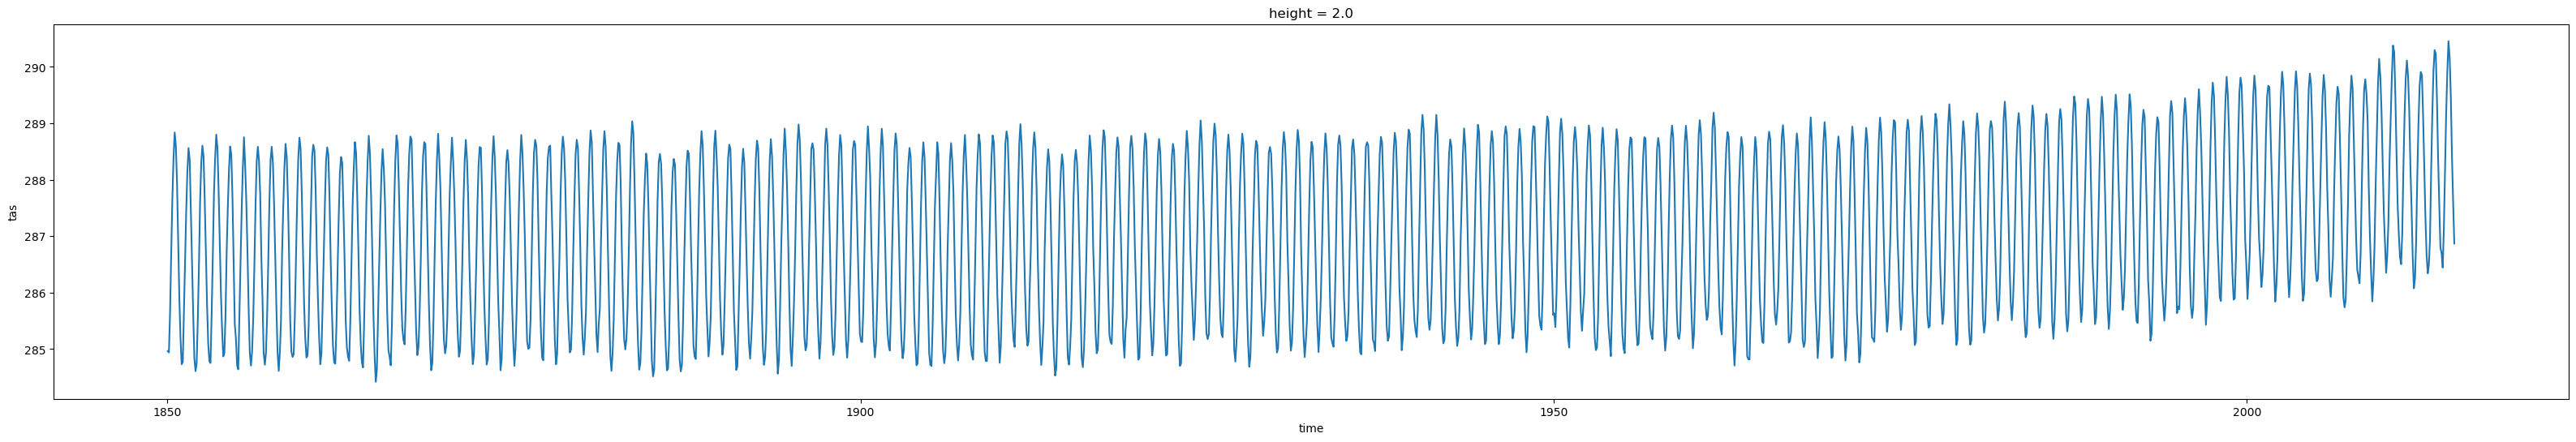

In [73]:
#plot time-series of global temperatures
fig, ax = plt.subplots(figsize = (40,6))
ds_tas_canesm5_merged.tas.plot(ax=ax)

### 1.2 Loading Multiple Models

In [74]:
#GCM picked out
gcm_list = ['NorESM2-MM',
 'ACCESS-CM2',
 'MPI-ESM1-2-LR',
 'KACE-1-0-G',
 'FGOALS-f3-L']
gcm_5_models = df[(df['source_id'] == 'NorESM2-MM') | (df['source_id'] == 'ACCESS-CM2') | (df['source_id'] == 'MPI-ESM1-2-LR') | 
(df['source_id']=='KACE-1-0-G')| (df['source_id'] == 'FGOALS-f3-L')]
gcm_5_models['source_id'].unique()

array(['FGOALS-f3-L', 'MPI-ESM1-2-LR', 'KACE-1-0-G', 'ACCESS-CM2',
       'NorESM2-MM'], dtype=object)

In [75]:
#time index to assign model times to
new_time_index=pd.date_range('1850-01-01', '2099-12-31', freq='ME')
new_time_index

DatetimeIndex(['1850-01-31', '1850-02-28', '1850-03-31', '1850-04-30',
               '1850-05-31', '1850-06-30', '1850-07-31', '1850-08-31',
               '1850-09-30', '1850-10-31',
               ...
               '2099-03-31', '2099-04-30', '2099-05-31', '2099-06-30',
               '2099-07-31', '2099-08-31', '2099-09-30', '2099-10-31',
               '2099-11-30', '2099-12-31'],
              dtype='datetime64[ns]', length=3000, freq='ME')

In [76]:
#load multiple models
ds_list = list()
for source in gcm_list:
    df_hist_tas=df.query  ("activity_id=='CMIP'         & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'& member_id=='r1i1p1f1' & source_id== @source")
    df_ssp585_tas=df.query("activity_id=='ScenarioMIP'  & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp585'    & member_id=='r1i1p1f1' & source_id== @source")
    ds_hist_tas   =load_zarr_dset(df_hist_tas)
    ds_ssp585_tas =load_zarr_dset(df_ssp585_tas)
    #concat data
    ds_all = xr.concat([ds_hist_tas, ds_ssp585_tas], dim = ('time'), coords='all', compat = 'override')
    #print(source) checking if each source starts at 1850
    #print(ds_all.time[0])
    #global mean w weights
    weights = np.cos(np.deg2rad(ds_all.tas.lat))
    ds_all = ds_all.weighted(weights).mean(dim=('lon', 'lat'))
    #slice to specific period and reassign new time index
    ds_all = ds_all.isel(time=slice(0,3000))
    ds_all = ds_all.assign(time=new_time_index)
    #add to list
    ds_list.append(ds_all)

ob_all = xr.concat(ds_list, dim = 'model', coords = 'minimal',compat='override')
ob_all

C:\Users\panda\miniconda3\envs\temp_var\Lib\site-packages\xarray\coding\times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
C:\Users\panda\miniconda3\envs\temp_var\Lib\site-packages\xarray\coding\times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
C:\Users\panda\miniconda3\envs\temp_var\Lib\site-packages\xarray\core\indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()


<xarray.Dataset>
Dimensions:  (time: 3000, model: 5)
Coordinates:
    height   (time) float64 2.0 2.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0 2.0 2.0
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2099-12-31
Dimensions without coordinates: model
Data variables:
    tas      (model, time) float64 dask.array<chunksize=(1, 241), meta=np.ndarray>

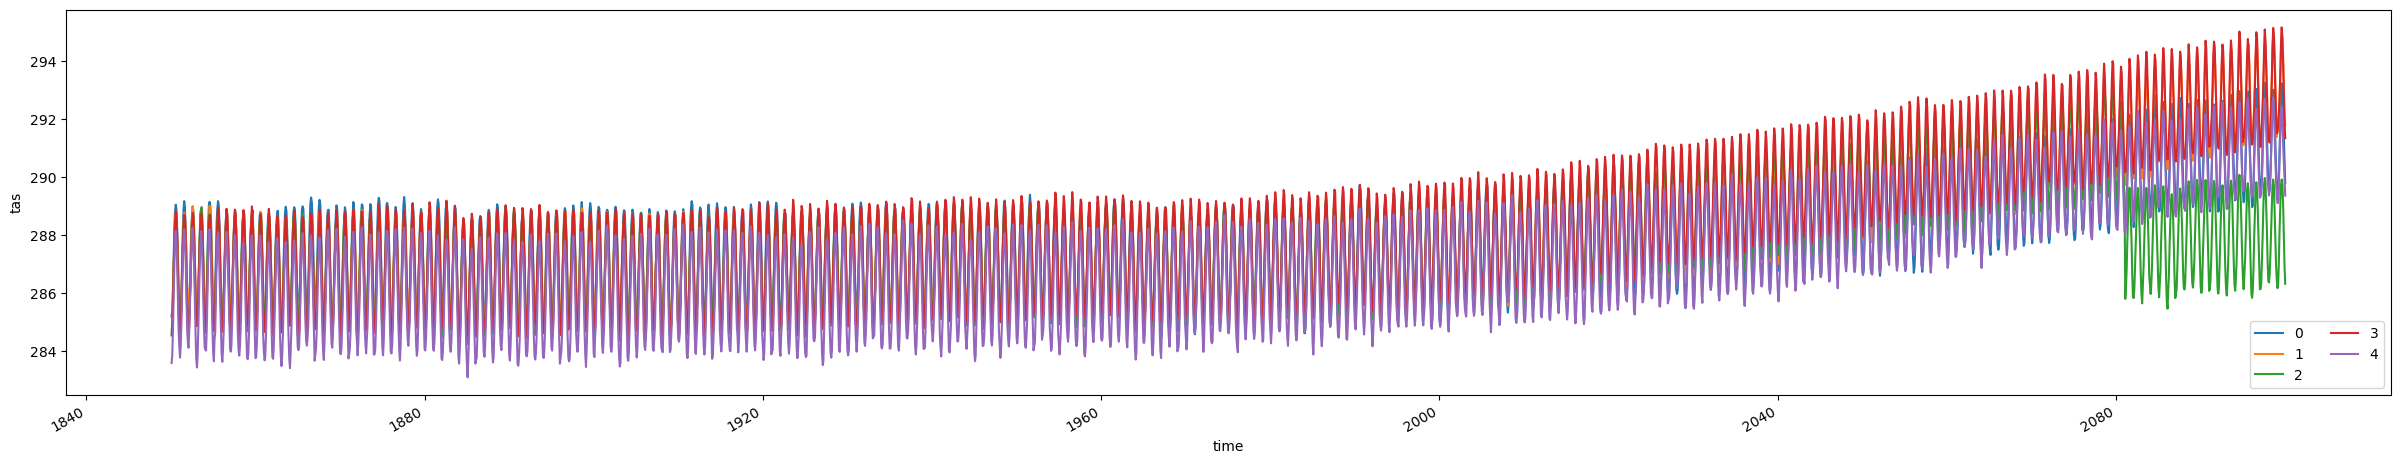

In [77]:
fig, ax = plt.subplots(figsize = (30,5))
lines = ob_all.tas.plot.line(ax=ax,hue='model', add_legend=False) #accesses tas variable and has each model number set as a diff color
labels = range(5) #adds labels
plt.legend(lines, labels, ncol=2, loc='lower right') 

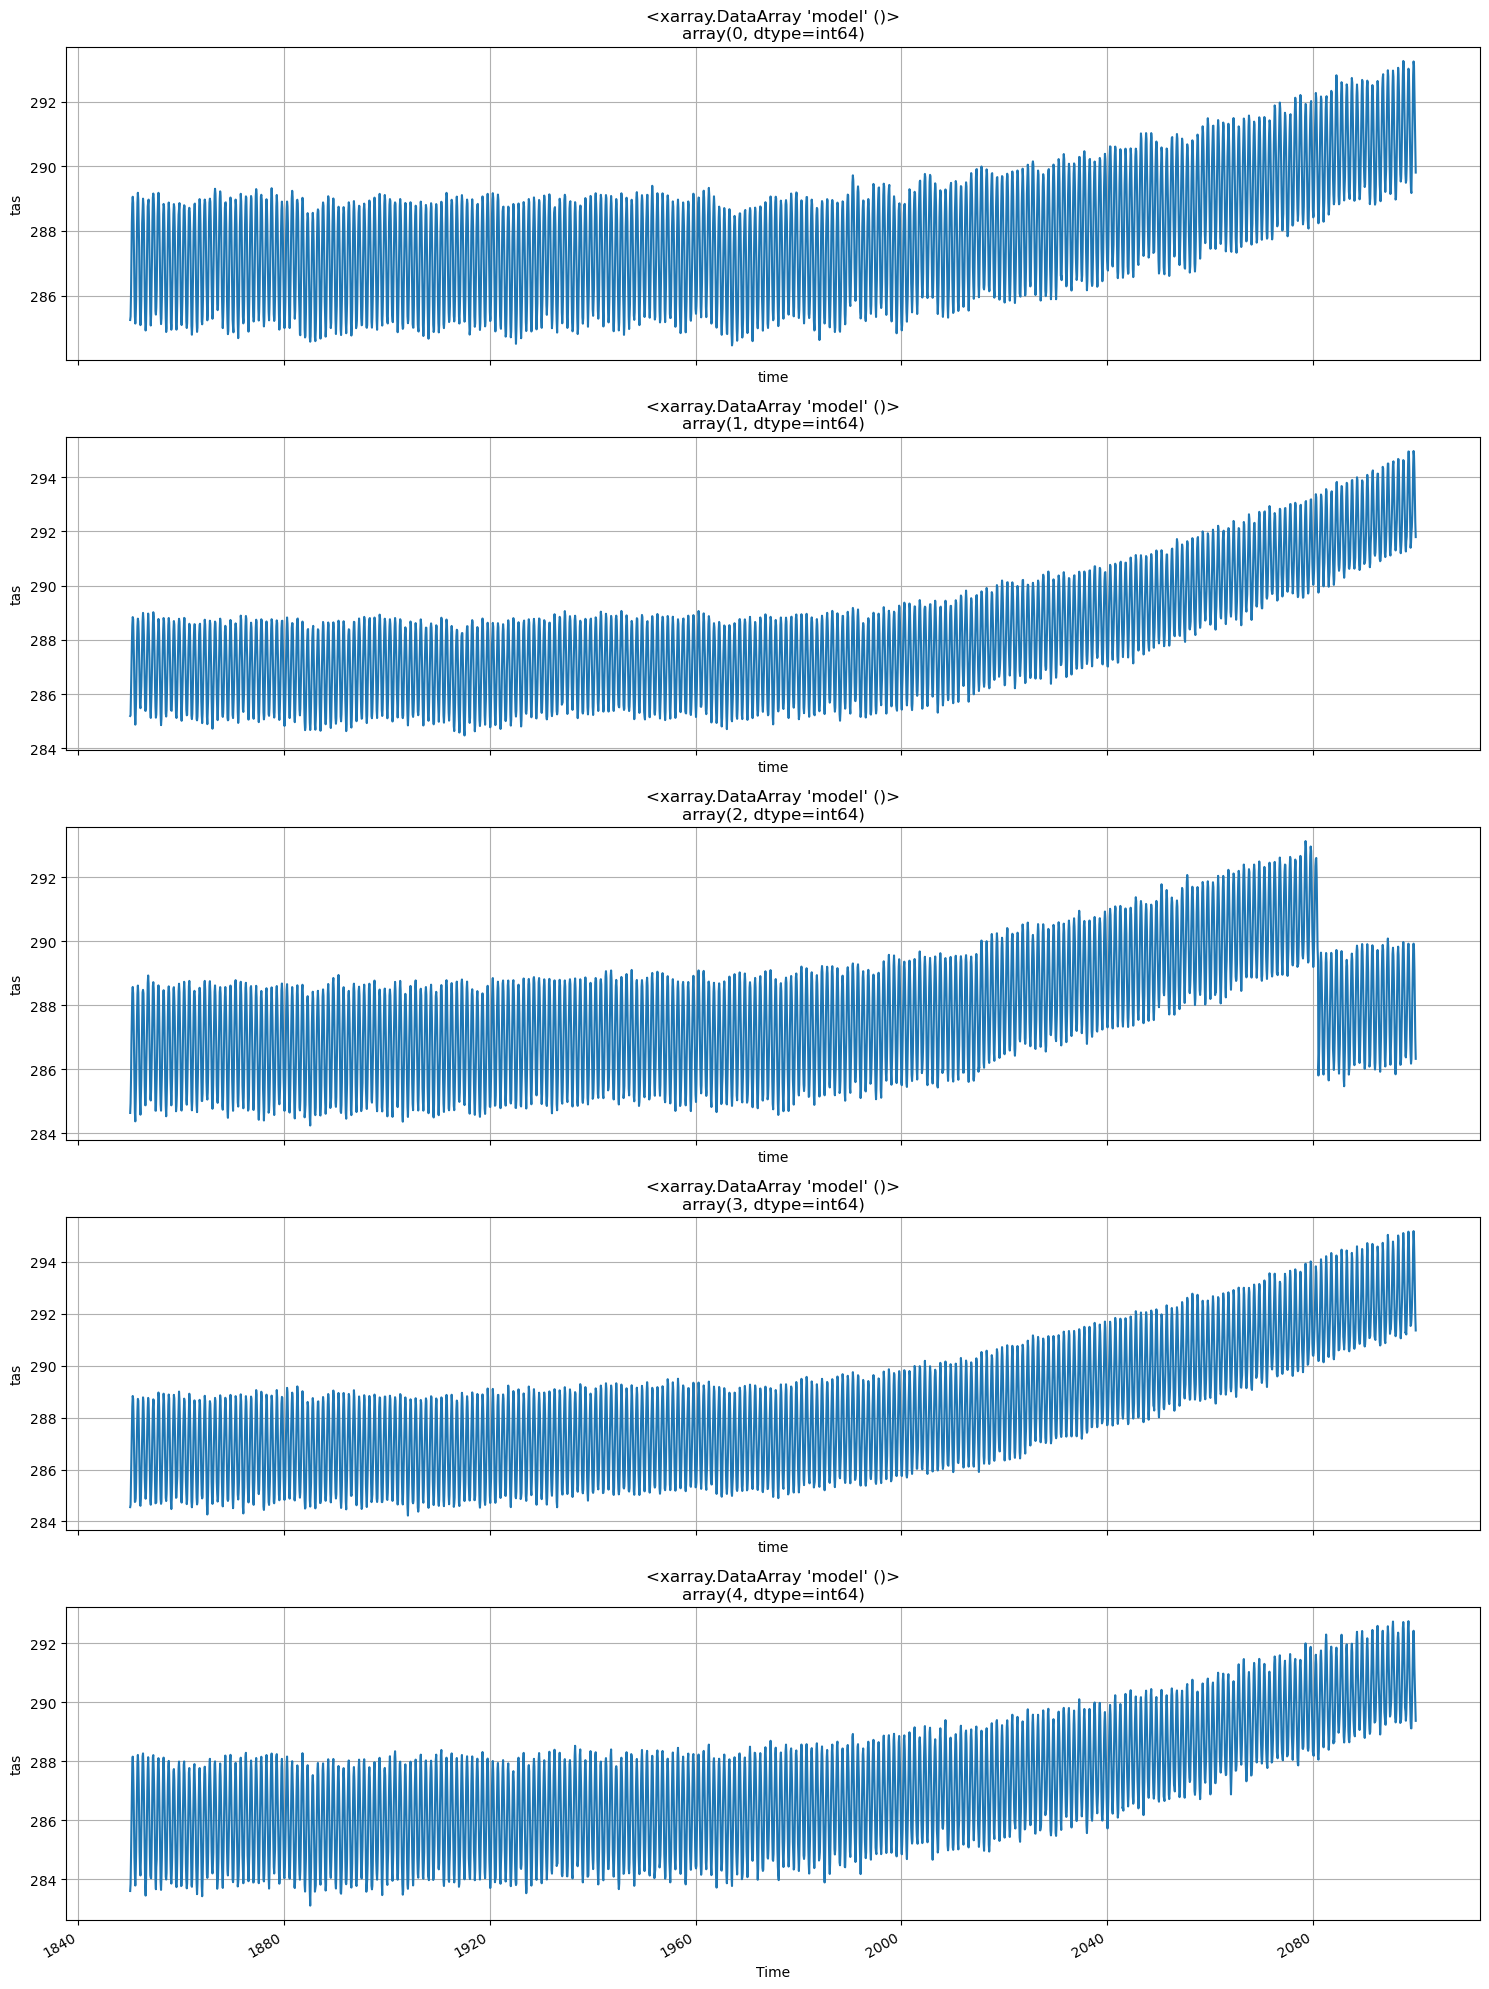

In [78]:
fig, axs = plt.subplots(5, 1, figsize=(15, 20), sharex=True)
for i, model in enumerate(ob_all.model): #enumerate returns iterator of pairs, each pair contains the index and the corresponding element from the iterable
    ob_all.sel(model=model).tas.plot(ax=axs[i], label=model) #selects each model and the tas variable, plots over each axes
    axs[i].set_title(model) #shows what model number
    axs[i].set_ylabel('tas')
    axs[i].grid(True) #makes gridlines on plot
axs[-1].set_xlabel('Time') 
plt.tight_layout() #creates a better layout for subplots
plt.show()

In [79]:
#adding in model name for coordinates instead of number
ds_list2 = list()
for source in gcm_list:
    df_hist_tas=df.query  ("activity_id=='CMIP'         & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'& member_id=='r1i1p1f1' & source_id== @source")
    df_ssp585_tas=df.query("activity_id=='ScenarioMIP'  & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp585'    & member_id=='r1i1p1f1' & source_id== @source")
    ds_hist_tas   =load_zarr_dset(df_hist_tas)
    ds_ssp585_tas =load_zarr_dset(df_ssp585_tas)
    #concat data
    ds_all = xr.concat([ds_hist_tas, ds_ssp585_tas], dim = ('time'), coords='all', compat = 'override')
    #print(source) checking if each source starts at 1850
    #print(ds_all.time[0])
    #global mean w weights
    weights = np.cos(np.deg2rad(ds_all.tas.lat))
    ds_all = ds_all.weighted(weights).mean(dim=('lon', 'lat'))
    #slice to specific period and reassign new time index
    ds_all = ds_all.isel(time=slice(0,3000))
    ds_all = ds_all.assign(time=new_time_index)
    ds_all = ds_all.assign_coords(model=source) #creates model coordinate for the source
    #add to list
    ds_list2.append(ds_all)
ob_all2 = xr.concat(ds_list2, dim = 'model', coords = 'minimal',compat='override')
ob_all2

C:\Users\panda\miniconda3\envs\temp_var\Lib\site-packages\xarray\coding\times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
C:\Users\panda\miniconda3\envs\temp_var\Lib\site-packages\xarray\coding\times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
C:\Users\panda\miniconda3\envs\temp_var\Lib\site-packages\xarray\core\indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()


<xarray.Dataset>
Dimensions:  (time: 3000, model: 5)
Coordinates:
    height   (time) float64 2.0 2.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0 2.0 2.0
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2099-12-31
  * model    (model) <U13 'NorESM2-MM' 'ACCESS-CM2' ... 'FGOALS-f3-L'
Data variables:
    tas      (model, time) float64 dask.array<chunksize=(1, 241), meta=np.ndarray>

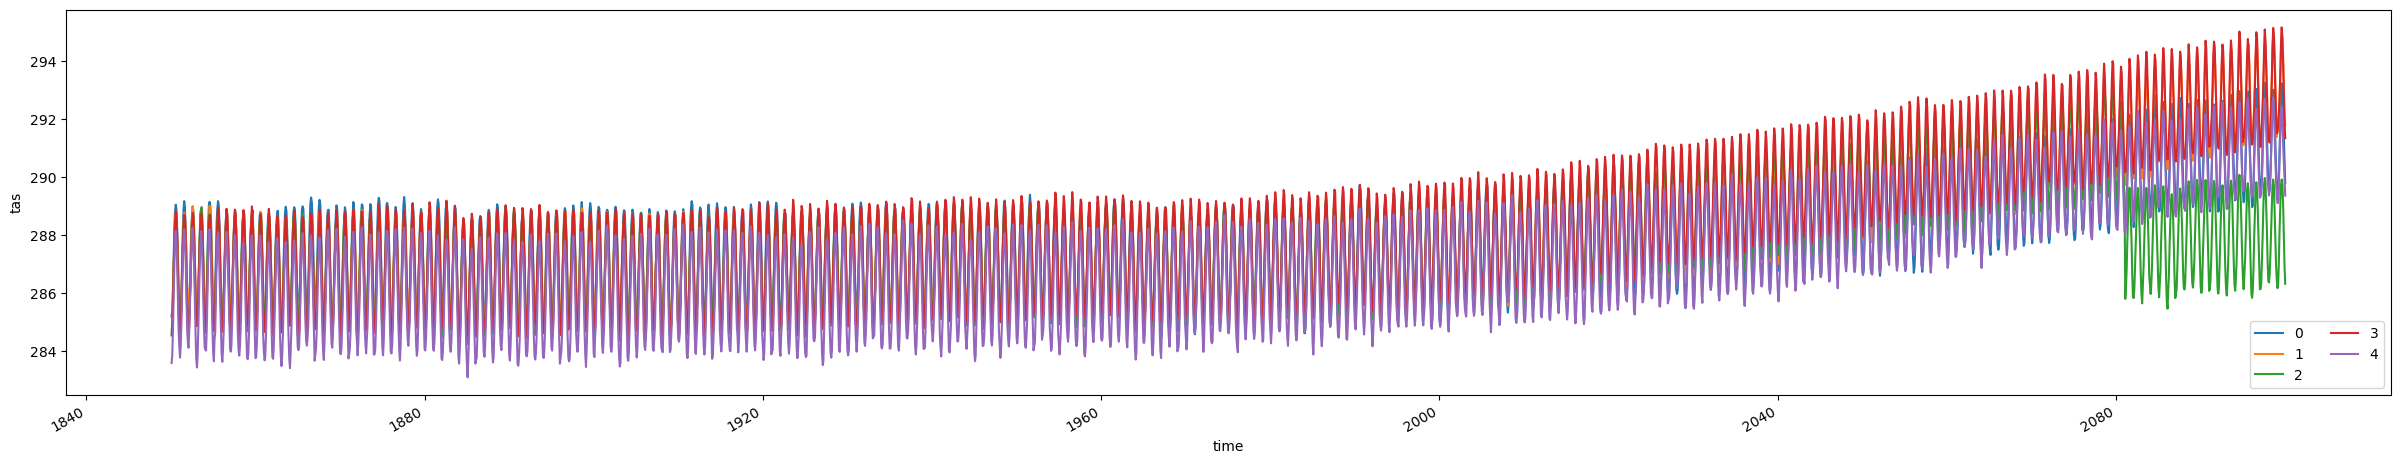

In [80]:
fig, ax = plt.subplots(figsize = (30,5))
lines = ob_all2.tas.plot.line(ax=ax,hue='model', add_legend=False) #accesses tas variable and has each model number set as a diff color
labels = range(5) #adds labels
plt.legend(lines, labels, ncol=2, loc='lower right') 

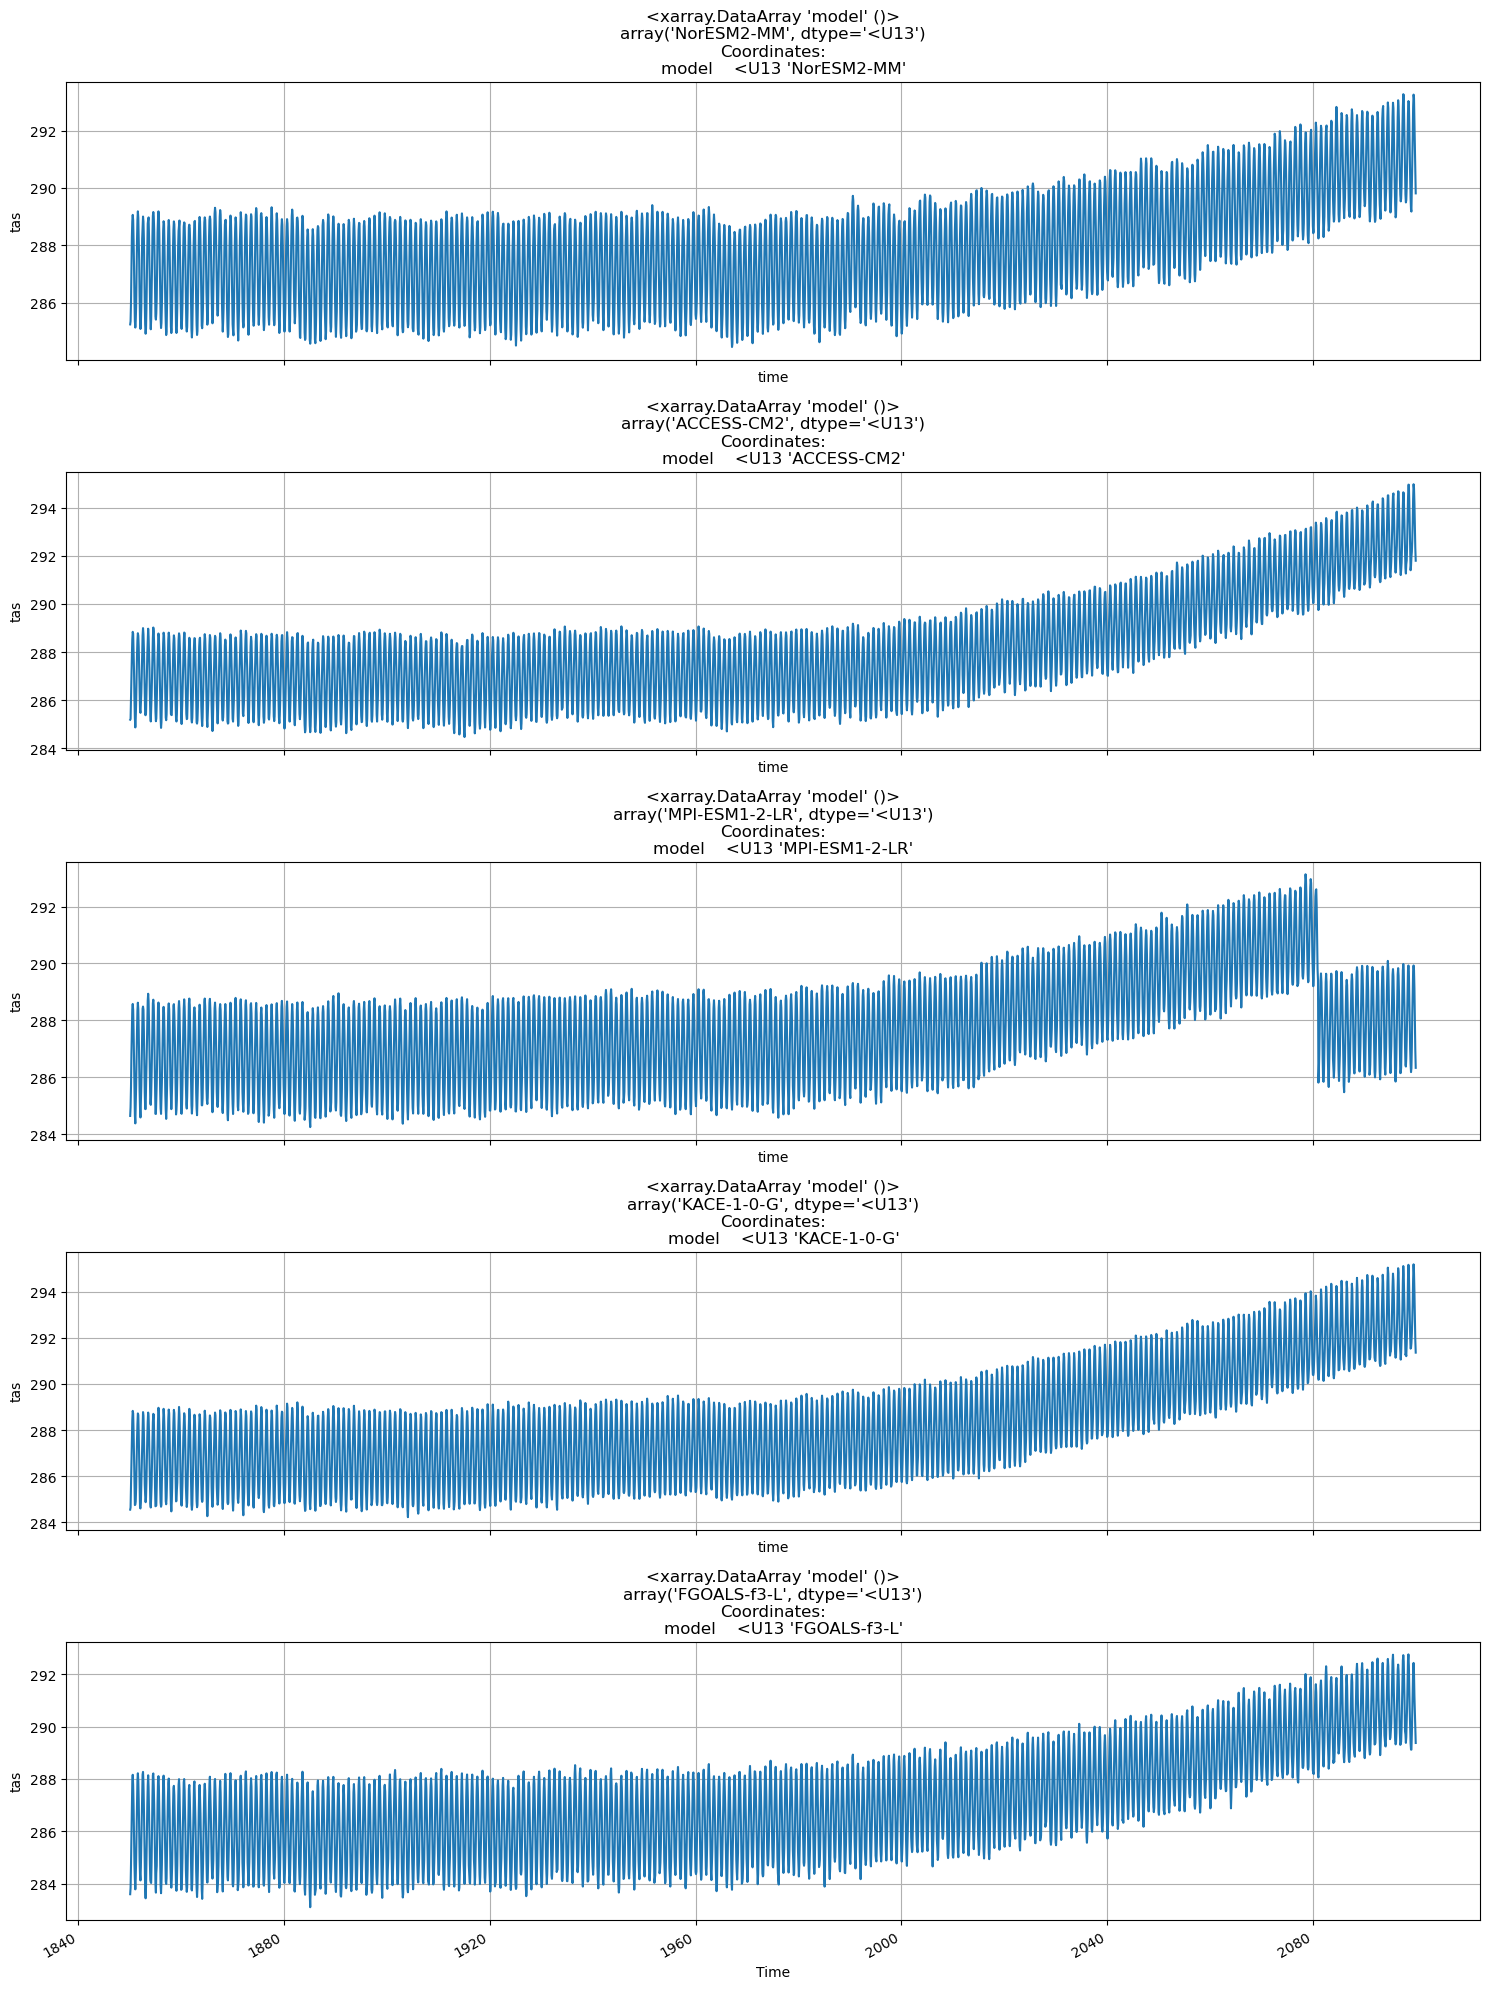

In [81]:
fig, axs = plt.subplots(5, 1, figsize=(15, 20), sharex=True)
for i, model in enumerate(ob_all2.model): #enumerate returns iterator of pairs, each pair contains the index and the corresponding element from the iterable
    ob_all2.sel(model=model).tas.plot(ax=axs[i], label=model) #selects each model and the tas variable, plots over each axes
    axs[i].set_title(model) #shows what model number
    axs[i].set_ylabel('tas')
    axs[i].grid(True) #makes gridlines on plot
axs[-1].set_xlabel('Time') 
plt.tight_layout() #creates a better layout for subplots
plt.show()

#### Trying to Fix Model 'MPI-ESM1-2-LR' 

In [82]:
temp_ob_2060 = ob_all2.tas.sel(time = slice('2060', '2099'))
temp_model_2_2060 = (temp_ob_2060.model == 'MPI-ESM1-2-LR').values
temp_model_2_2060

array([False, False,  True, False, False])

In [83]:
df_hist_tas_temp=df.query  ("activity_id=='CMIP'         & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'& member_id=='r1i1p1f1' & source_id== 'MPI-ESM1-2-LR'")
df_ssp585_tas_temp=df.query("activity_id=='ScenarioMIP'  & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp585'    & member_id=='r1i1p1f1' & source_id== 'MPI-ESM1-2-LR'")
ds_hist_tas_temp   =load_zarr_dset(df_hist_tas)
ds_ssp585_tas_temp =load_zarr_dset(df_ssp585_tas)
#concat data
ds_all_temp = xr.concat([ds_hist_tas, ds_ssp585_tas], dim = ('time'), coords='all', compat = 'override')
#global mean w weights
weights = np.cos(np.deg2rad(ds_all_temp.tas.lat))
ds_all_temp = ds_all_temp.weighted(weights).mean(dim=('lon', 'lat'))
#slice to specific period and reassign new time index
ds_all_temp = ds_all_temp.isel(time=slice(0,3000))
ds_all_temp = ds_all_temp.assign(time=new_time_index)
ds_all_temp = ds_all_temp.sel(time=slice('2080','2099'))
model_2_temp = list(ds_all_temp.tas.values)

Text(0.5, 1.0, 'MPI-ESM1-2-LR Model from 2080 to 2100')

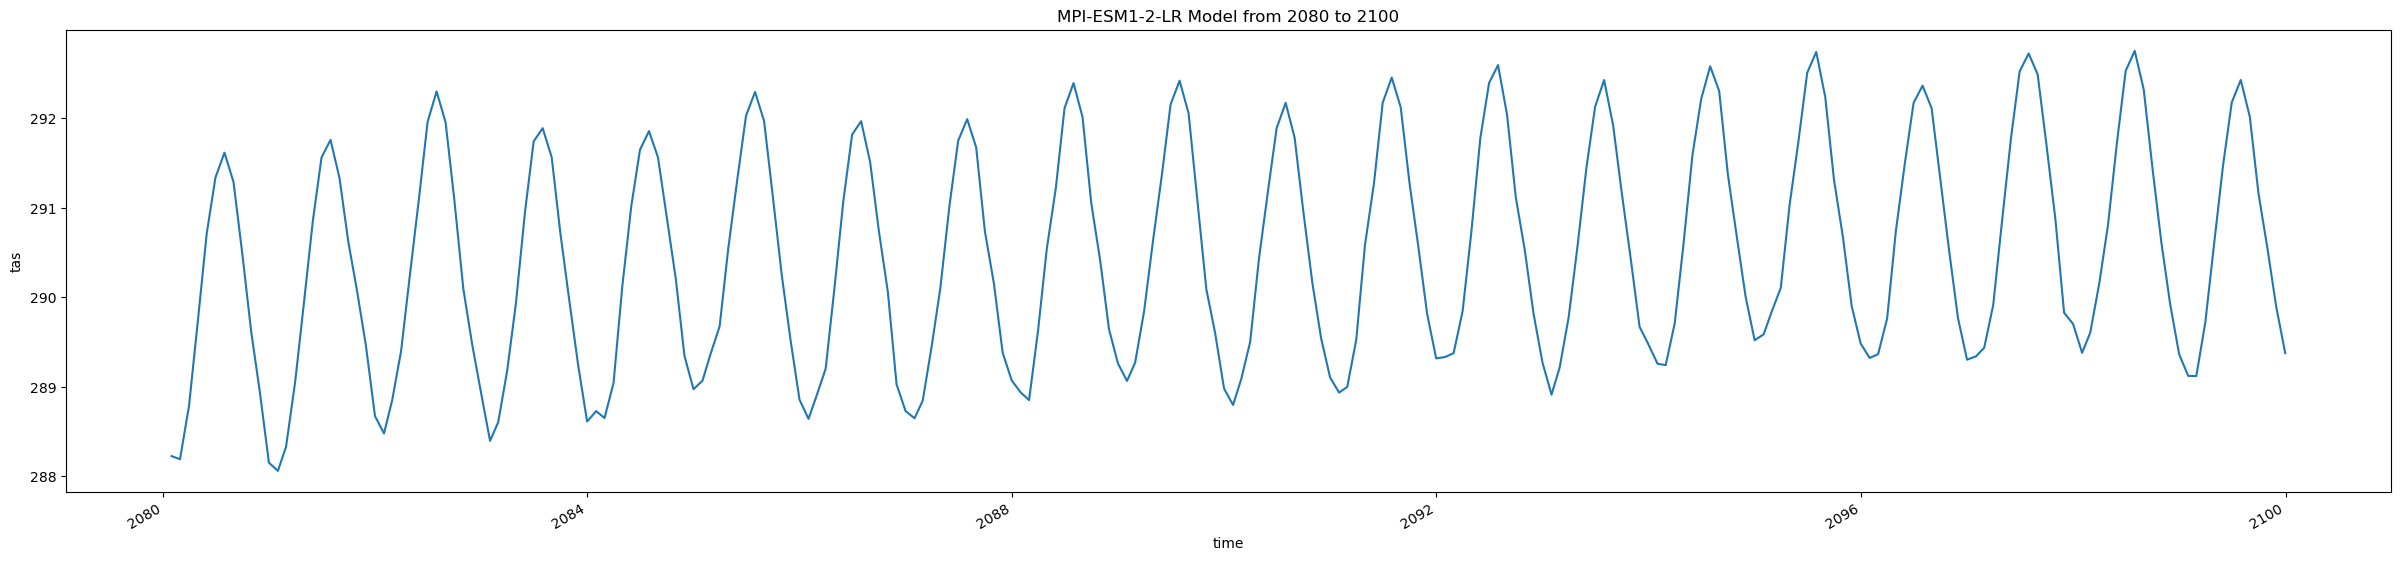

In [84]:
fig, ax = plt.subplots(figsize = (30,6))
ds_all_temp.tas.plot(ax=ax)
ax.set_title('MPI-ESM1-2-LR Model from 2080 to 2100')

In [85]:
ds_temp_temp = ob_all.tas.sel(time = slice('2080', '2099'))
tas_temp_list = np.array(ds_temp_temp.values)
tas_temp_list

array([[288.42165964, 288.47628849, 289.26362263, ..., 291.42806119,
        290.51271759, 289.80965078],
       [290.03078127, 290.19638629, 290.59828033, ..., 293.27345052,
        292.3370407 , 291.79329048],
       [289.19850862, 289.45453055, 289.97655744, ..., 288.02319916,
        286.97402242, 286.3299763 ],
       [290.3754013 , 290.48980043, 291.01829658, ..., 292.85720598,
        291.92012889, 291.3528017 ],
       [288.22285982, 288.18792999, 288.7861784 , ..., 290.54241273,
        289.89450653, 289.37419417]])

In [86]:
count = 0
for i in range(tas_temp_list.shape[0]):
    for j in range(tas_temp_list.shape[1]):
        value = tas_temp_list[i, j]
        if value < 286:
            count+=1
count

15

In [87]:
model_2_temp

[288.22285981680045,
 288.18792999063726,
 288.7861783986307,
 289.7222532269614,
 290.7149243297954,
 291.3399412555336,
 291.61728746939104,
 291.29059748469274,
 290.4968609622355,
 289.6142400369372,
 288.93368192001884,
 288.14886826955023,
 288.05806682681606,
 288.3293105726962,
 289.04636545128324,
 289.9227397574354,
 290.85100051093247,
 291.5638229374953,
 291.76046595181396,
 291.3312160923365,
 290.6236634459515,
 290.05716664285967,
 289.45357403107266,
 288.67101975497036,
 288.47626856386137,
 288.84598293118705,
 289.40155740545015,
 290.24575231739453,
 291.09546848753695,
 291.9605769044559,
 292.30241134888763,
 291.9560372614898,
 291.09129023580306,
 290.09540739165817,
 289.4812245603251,
 288.93151272677176,
 288.3935383432376,
 288.60144710370986,
 289.18011082269817,
 289.9324465690538,
 290.9461654180168,
 291.7431670500295,
 291.8911085516486,
 291.5681723268256,
 290.7159226939194,
 289.9563301129077,
 289.2451381773899,
 288.60991617175756,
 288.7257170247

In [88]:
count = 0
for i in range(len(model_2_temp)):
    if i < 286:
       count+=1
count

240

#### Expand Analysis to All Models

In [89]:
ds_list_all = list()
for source in source_list:
    df_hist_tas=df.query  ("activity_id=='CMIP'         & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'& member_id=='r1i1p1f1' & source_id== @source")
    df_ssp585_tas=df.query("activity_id=='ScenarioMIP'  & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp585'    & member_id=='r1i1p1f1' & source_id== @source")
    ds_hist_tas   =load_zarr_dset(df_hist_tas)
    ds_ssp585_tas =load_zarr_dset(df_ssp585_tas)
    #concat data
    ds_all = xr.concat([ds_hist_tas, ds_ssp585_tas], dim = ('time'), coords='all', compat = 'override')
    print("\n"+source) #checking if each source starts at 1850
    print("First time index " +str(ds_all.time[0]))
    print("Last time index " +str(ds_all.time[-1]))
    #global mean w weights
    weights = np.cos(np.deg2rad(ds_all.tas.lat))
    ds_all = ds_all.weighted(weights).mean(dim=('lon', 'lat'))
    #slice to specific period and reassign new time index
    ds_all = ds_all.isel(time=slice(0,3000))
    ds_all = ds_all.assign(time=new_time_index)
    ds_all = ds_all.assign_coords(model=source) #creates model coordinate for the source
    #add to list
    ds_list_all.append(ds_all)

ds_all_models = xr.concat(ds_list_all, dim = 'model', coords = 'minimal',compat='override')
ds_all_models


MRI-ESM2-0
First time index <xarray.DataArray 'time' ()>
array('1850-01-16T12:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    height   float64 2.0
    time     datetime64[ns] 1850-01-16T12:00:00
Attributes:
    axis:           T
    bounds:         time_bnds
    long_name:      time
    standard_name:  time
Last time index <xarray.DataArray 'time' ()>
array('2100-12-16T12:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    height   float64 2.0
    time     datetime64[ns] 2100-12-16T12:00:00
Attributes:
    axis:           T
    bounds:         time_bnds
    long_name:      time
    standard_name:  time

INM-CM4-8
First time index <xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(1850, 1, 16, 12, 0, 0, 0, has_year_zero=True),
      dtype=object)
Coordinates:
    height   float64 2.0
    time     object 1850-01-16 12:00:00
Attributes:
    axis:           T
    bounds:         time_bnds
    long_name:      time
    standard_name:  time
Last time index <xarray.Dat

C:\Users\panda\miniconda3\envs\temp_var\Lib\site-packages\xarray\coding\times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
C:\Users\panda\miniconda3\envs\temp_var\Lib\site-packages\xarray\coding\times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
C:\Users\panda\miniconda3\envs\temp_var\Lib\site-packages\xarray\core\indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()



ACCESS-ESM1-5
First time index <xarray.DataArray 'time' ()>
array('1850-01-16T12:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    height   float64 2.0
    time     datetime64[ns] 1850-01-16T12:00:00
Attributes:
    axis:           T
    bounds:         time_bnds
    long_name:      time
    standard_name:  time
Last time index <xarray.DataArray 'time' ()>
array(cftime.DatetimeProlepticGregorian(2300, 12, 16, 12, 0, 0, 0, has_year_zero=True),
      dtype=object)
Coordinates:
    height   float64 2.0
    time     object 2300-12-16 12:00:00
Attributes:
    axis:           T
    bounds:         time_bnds
    long_name:      time
    standard_name:  time

INM-CM5-0
First time index <xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(1850, 1, 16, 12, 0, 0, 0, has_year_zero=True),
      dtype=object)
Coordinates:
    height   float64 2.0
    time     object 1850-01-16 12:00:00
Attributes:
    axis:           T
    bounds:         time_bnds
    long_name:      time
    standard

C:\Users\panda\miniconda3\envs\temp_var\Lib\site-packages\xarray\coding\times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
C:\Users\panda\miniconda3\envs\temp_var\Lib\site-packages\xarray\coding\times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
C:\Users\panda\miniconda3\envs\temp_var\Lib\site-packages\xarray\core\indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()



ACCESS-CM2
First time index <xarray.DataArray 'time' ()>
array('1850-01-16T12:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    height   float64 2.0
    time     datetime64[ns] 1850-01-16T12:00:00
Attributes:
    axis:           T
    bounds:         time_bnds
    long_name:      time
    standard_name:  time
Last time index <xarray.DataArray 'time' ()>
array(cftime.DatetimeProlepticGregorian(2300, 12, 16, 12, 0, 0, 0, has_year_zero=True),
      dtype=object)
Coordinates:
    height   float64 2.0
    time     object 2300-12-16 12:00:00
Attributes:
    axis:           T
    bounds:         time_bnds
    long_name:      time
    standard_name:  time

EC-Earth3-Veg-LR
First time index <xarray.DataArray 'time' ()>
array('1850-01-16T12:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    height   float64 2.0
    time     datetime64[ns] 1850-01-16T12:00:00
Attributes:
    axis:           T
    bounds:         time_bnds
    long_name:      time
    standard_name:  time
Last ti

<xarray.Dataset>
Dimensions:  (time: 3000, model: 33)
Coordinates:
    height   (time) float64 2.0 2.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0 2.0 2.0
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2099-12-31
  * model    (model) <U16 'MRI-ESM2-0' 'INM-CM4-8' ... 'IITM-ESM' 'CanESM5'
Data variables:
    tas      (model, time) float64 dask.array<chunksize=(1, 126), meta=np.ndarray>

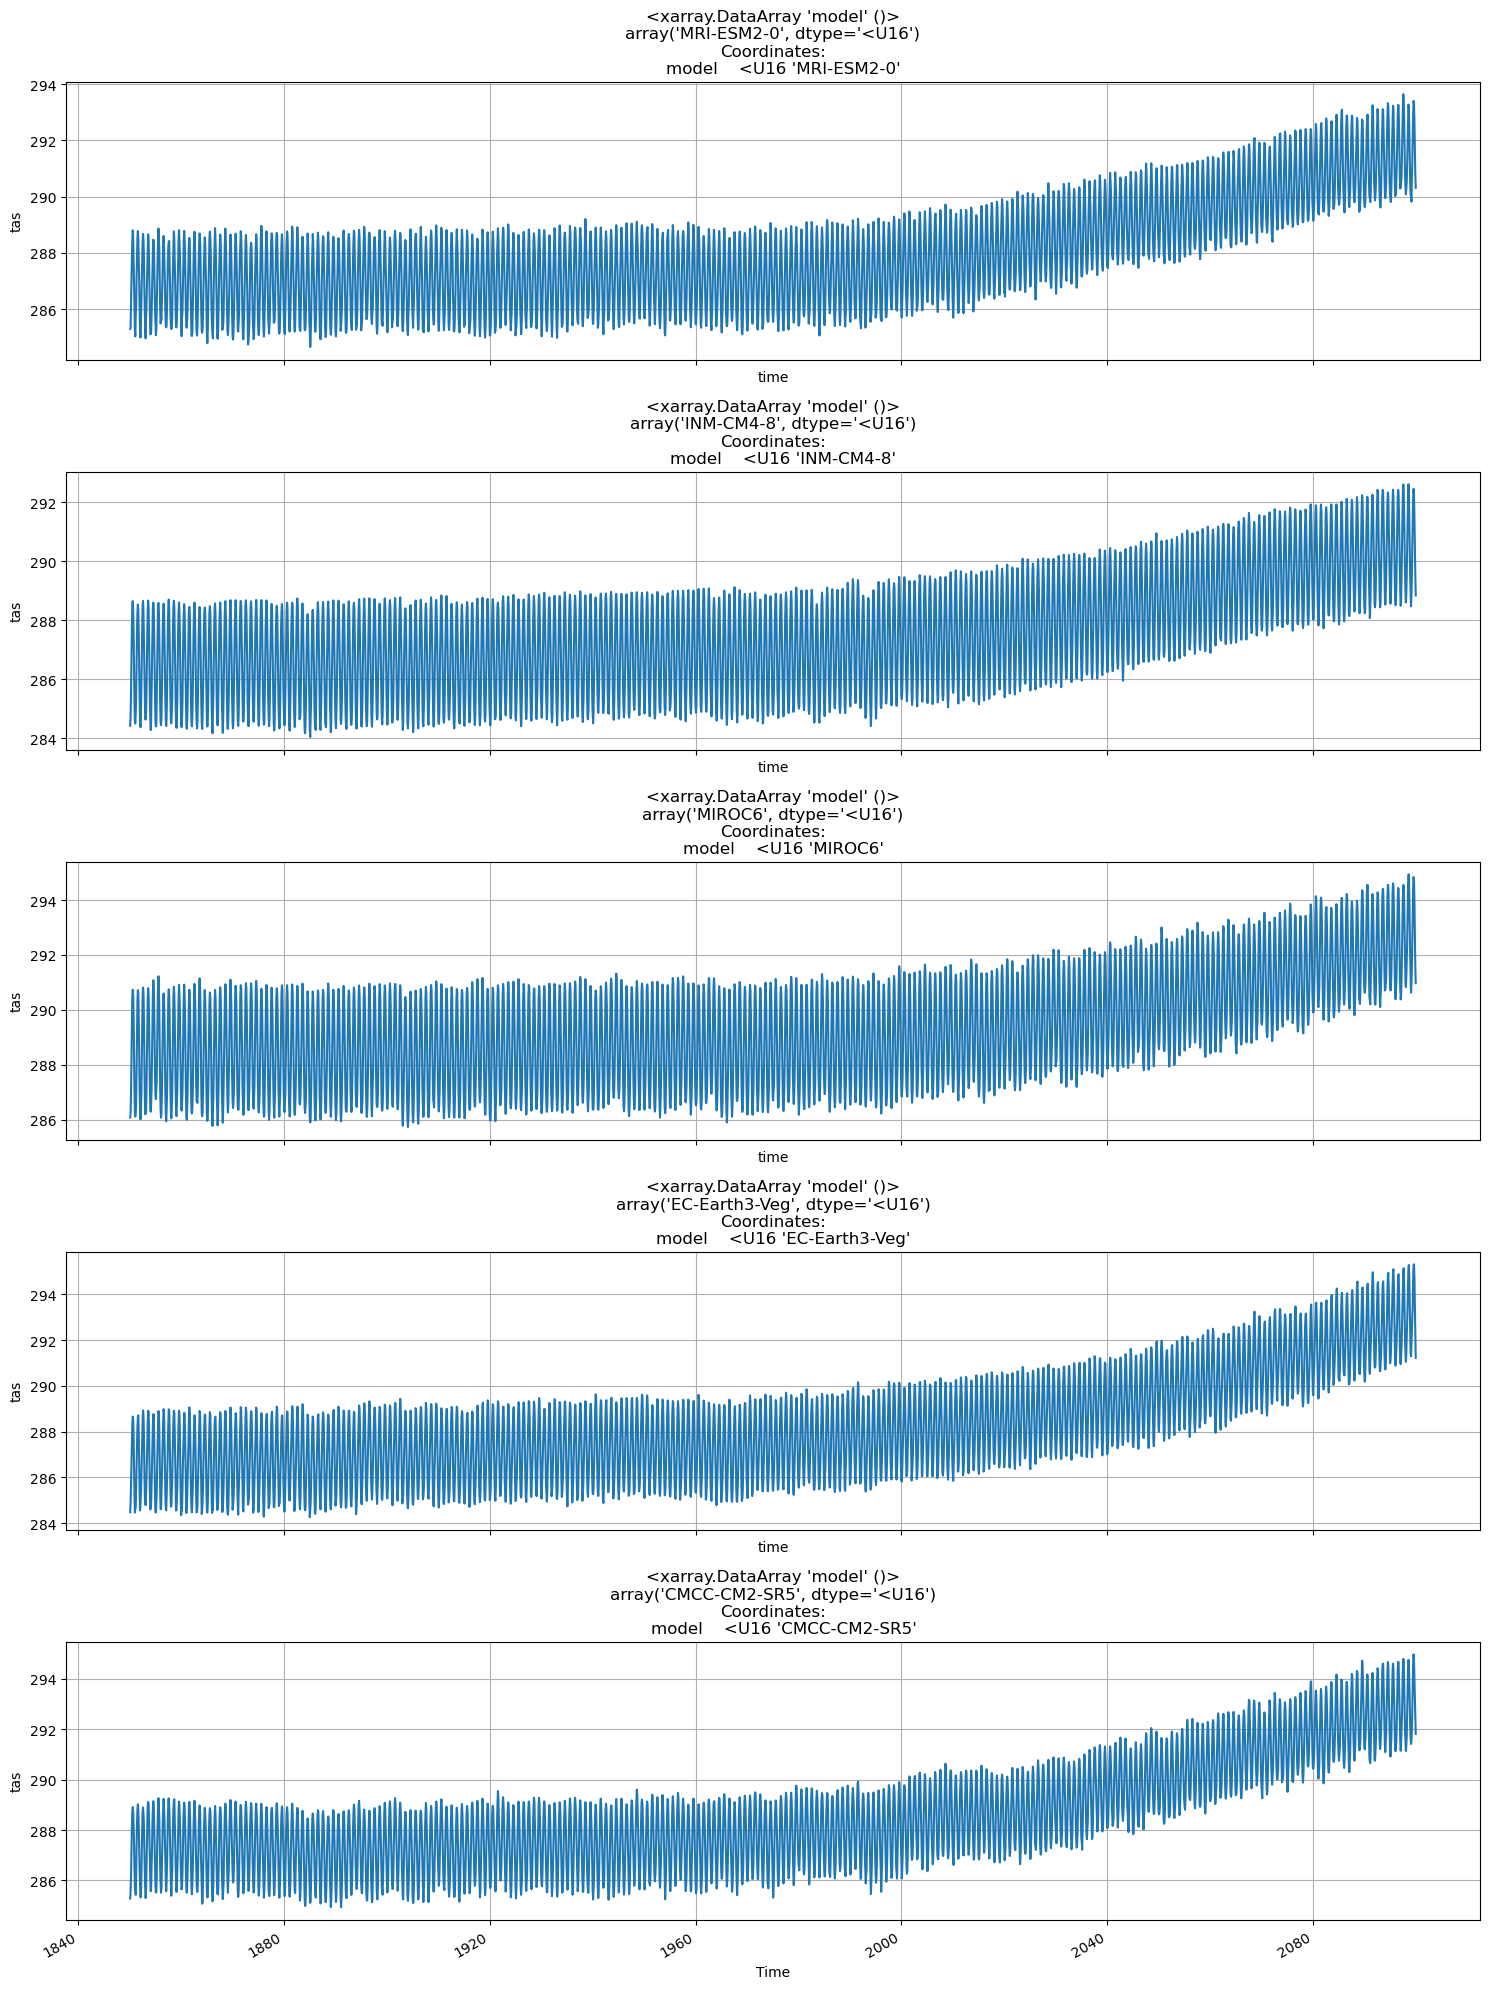

In [92]:
fig, axs = plt.subplots(5, 1, figsize=(15, 20), sharex=True)
fig_counter = 0
while fig_counter < 5:
    for i, model in enumerate(ds_all_models.model): #enumerate returns iterator of pairs, each pair contains the index and the corresponding element from the iterable
        if fig_counter >= 5:
            break
        ds_all_models.sel(model=model).tas.plot(ax=axs[i], label=model) #selects each model and the tas variable, plots over each axes
        axs[i].set_title(model) #shows what model number
        axs[i].set_ylabel('tas')
        axs[i].grid(True) #makes gridlines on plot
        fig_counter +=1
axs[-1].set_xlabel('Time') 
plt.tight_layout() #creates a better layout for subplots
plt.show()

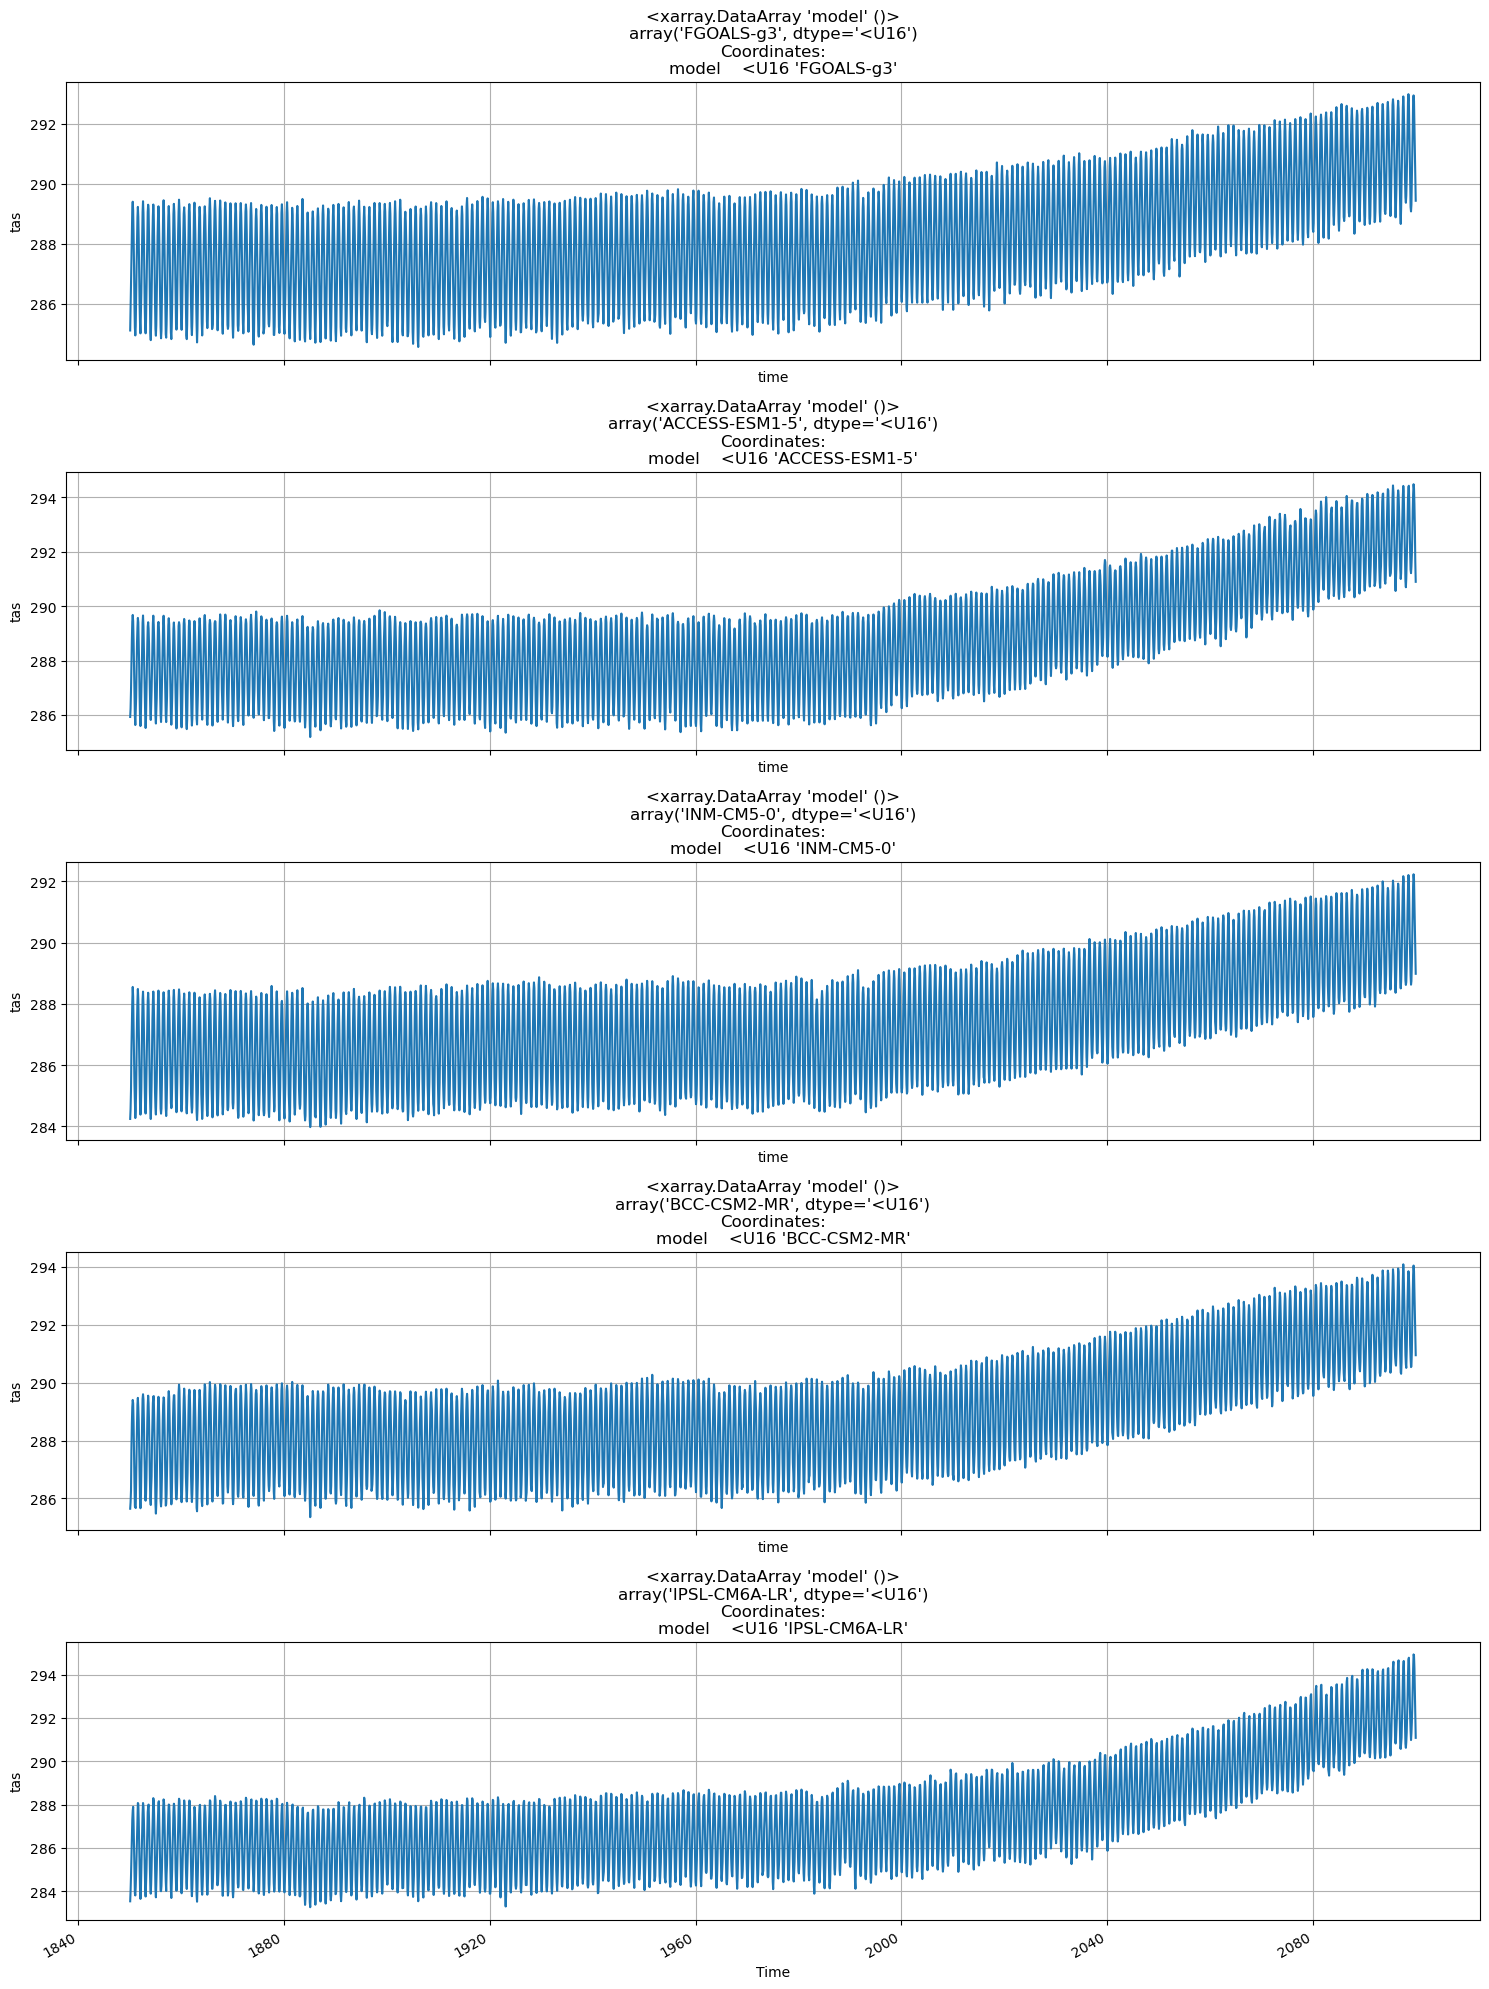

In [97]:
fig, axs = plt.subplots(5, 1, figsize=(15, 20), sharex=True)
fig_counter_2 = 5
while fig_counter_2 < 10: #made another while loop to separate the graphs and make it cleaner
    for i, model in enumerate(ds_all_models.model[5:]): #sliced from 5th index after last model figure shown in previous cell block (index should be same each time in dataset)
        if fig_counter_2 >= 10:
            break
        ds_all_models.sel(model=model).tas.plot(ax=axs[i], label=model) #selects each model and the tas variable, plots over each axes
        axs[i].set_title(model) #shows what model number
        axs[i].set_ylabel('tas')
        axs[i].grid(True) #makes gridlines on plot
        fig_counter_2 +=1
axs[-1].set_xlabel('Time') 
plt.tight_layout() #creates a better layout for subplots
plt.show()

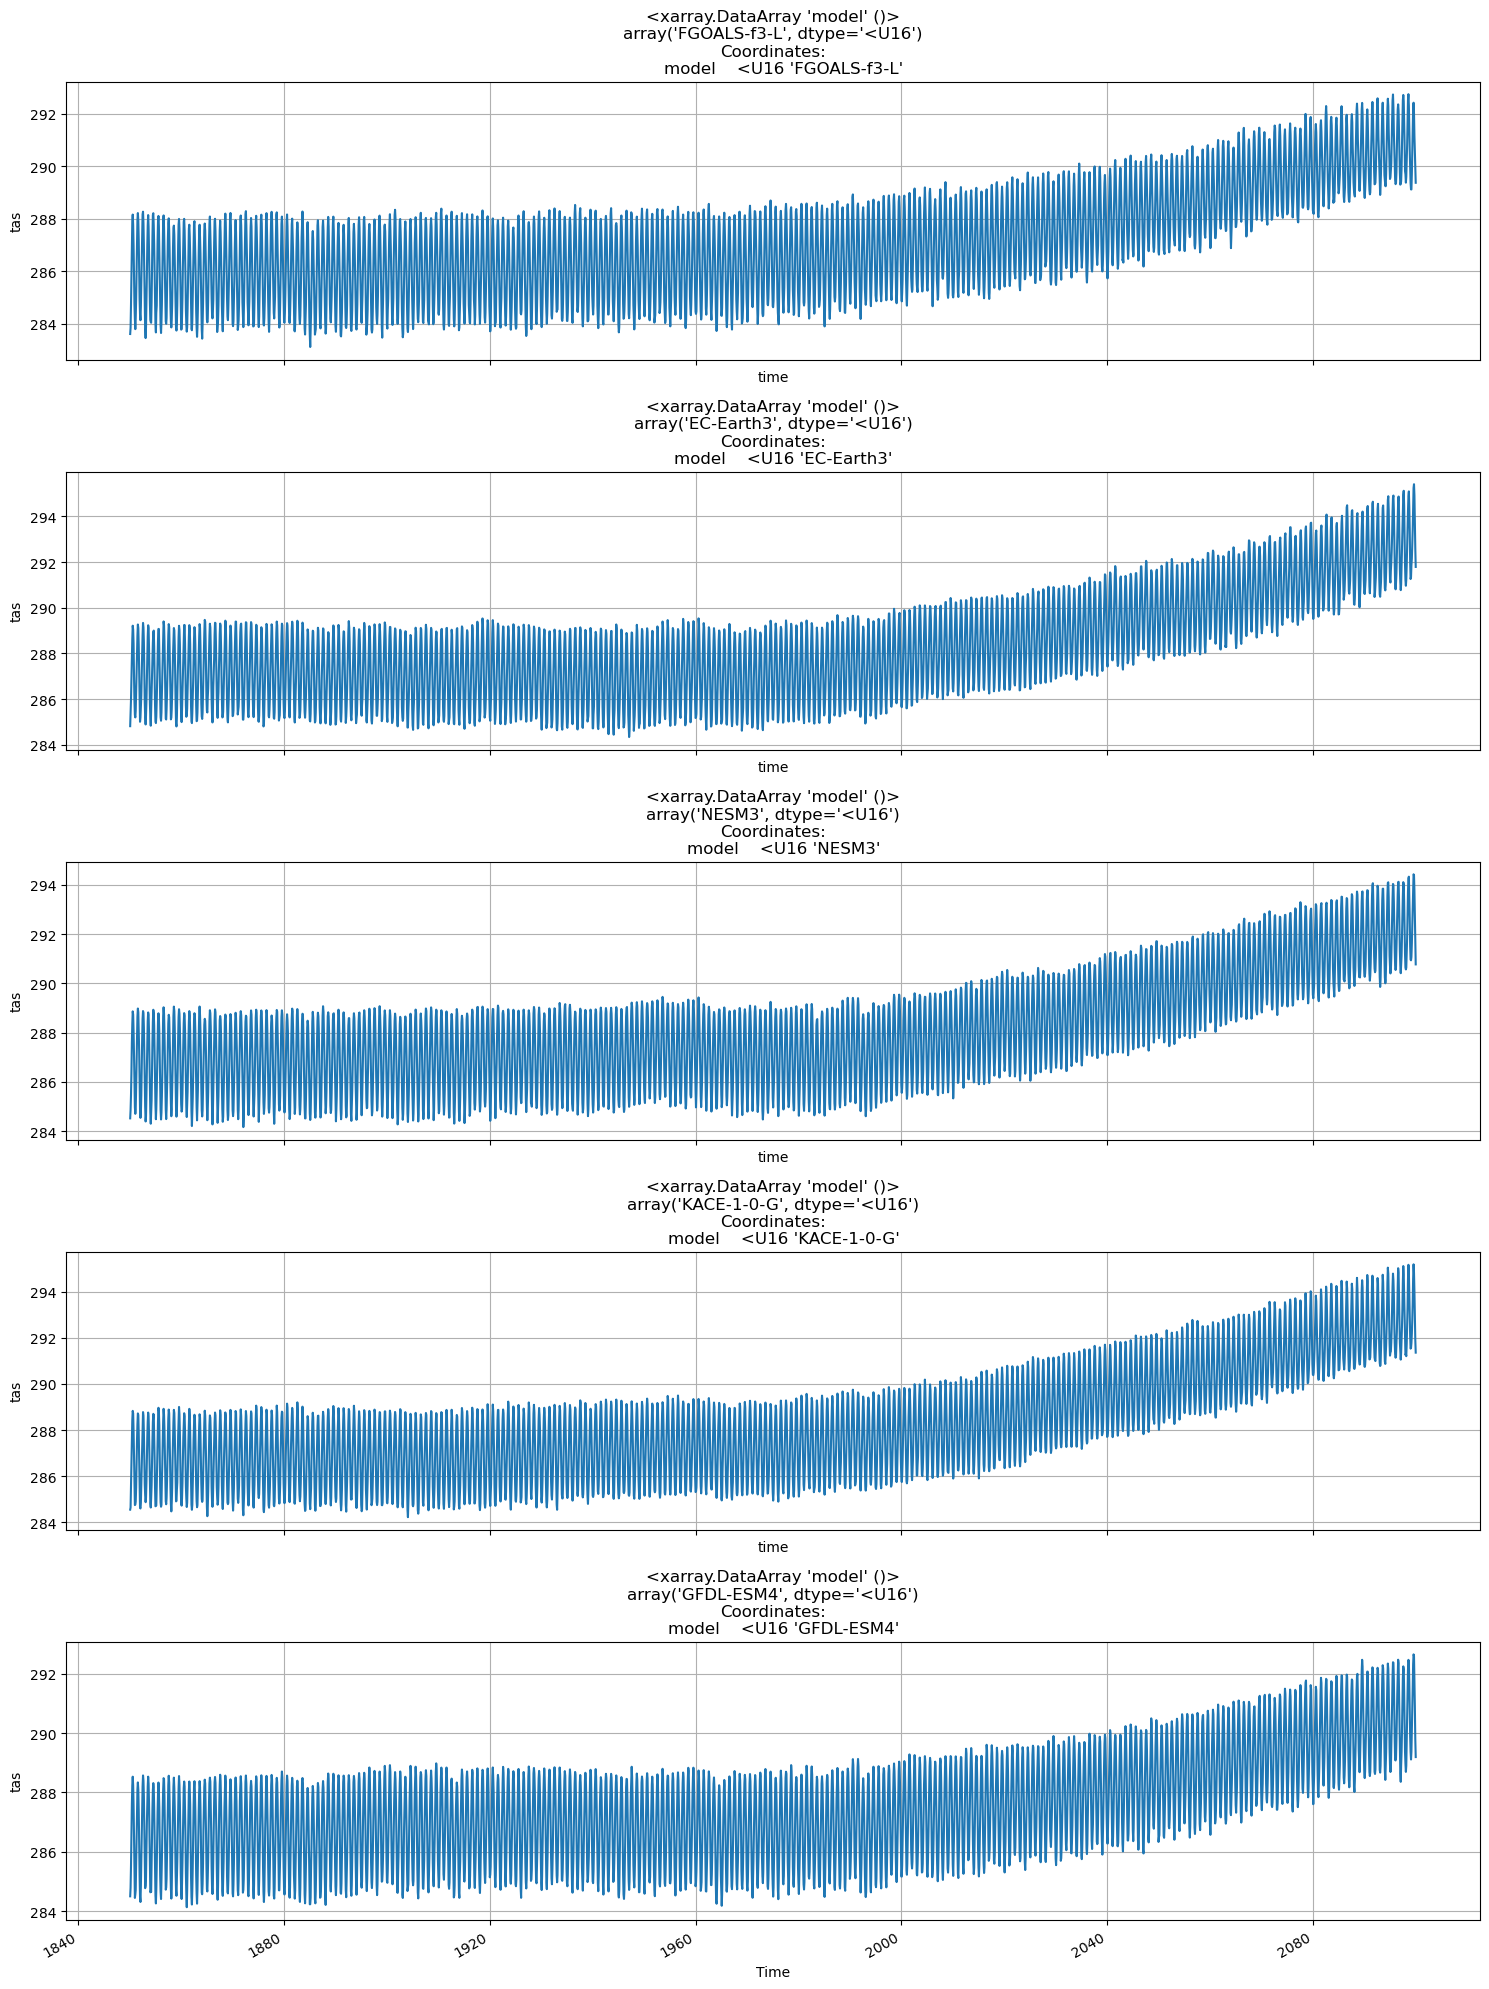

In [99]:
fig, axs = plt.subplots(5, 1, figsize=(15, 20), sharex=True)
fig_counter_3 = 10
while fig_counter_3 < 15: #made another while loop to separate the graphs and make it cleaner
    for i, model in enumerate(ds_all_models.model[10:]): #sliced from 10th index after last model figure shown in previous cell block (index should be same each time in dataset)
        if fig_counter_3 >= 15:
            break
        ds_all_models.sel(model=model).tas.plot(ax=axs[i], label=model) #selects each model and the tas variable, plots over each axes
        axs[i].set_title(model) #shows what model number
        axs[i].set_ylabel('tas')
        axs[i].grid(True) #makes gridlines on plot
        fig_counter_3 +=1
axs[-1].set_xlabel('Time') 
plt.tight_layout() #creates a better layout for subplots
plt.show()

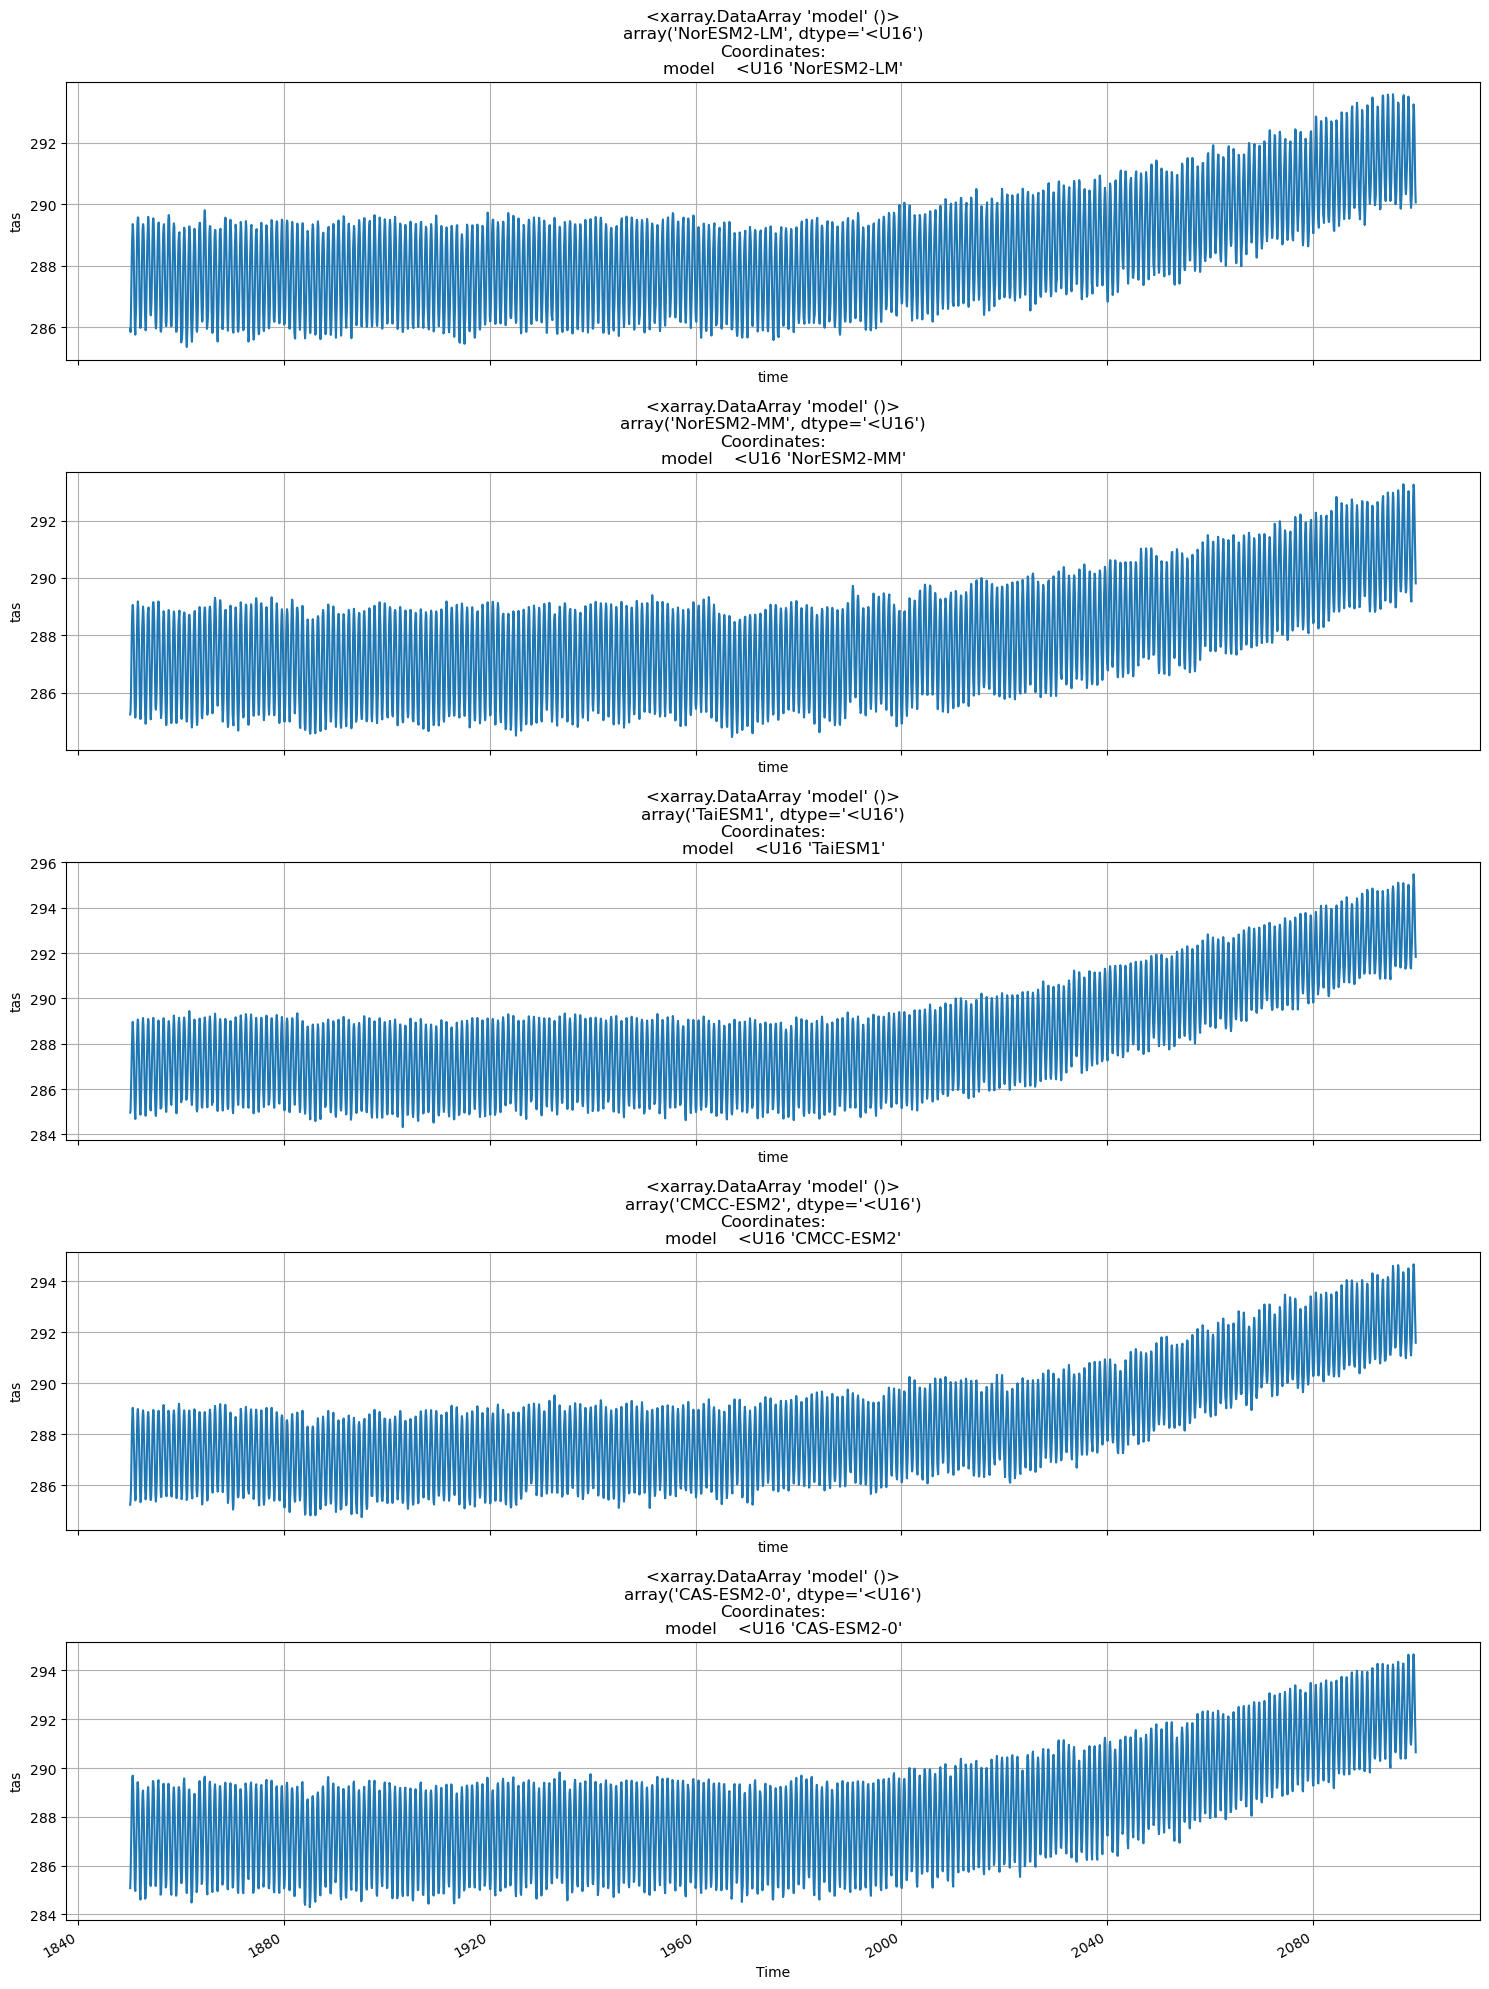

In [100]:
fig, axs = plt.subplots(5, 1, figsize=(15, 20), sharex=True)
fig_counter_4 = 15
while fig_counter_4 < 20: #made another while loop to separate the graphs and make it cleaner
    for i, model in enumerate(ds_all_models.model[15:]): #sliced from 15th index after last model figure shown in previous cell block (index should be same each time in dataset)
        if fig_counter_4 >= 20:
            break
        ds_all_models.sel(model=model).tas.plot(ax=axs[i], label=model) #selects each model and the tas variable, plots over each axes
        axs[i].set_title(model) #shows what model number
        axs[i].set_ylabel('tas')
        axs[i].grid(True) #makes gridlines on plot
        fig_counter_4 +=1
axs[-1].set_xlabel('Time') 
plt.tight_layout() #creates a better layout for subplots
plt.show()

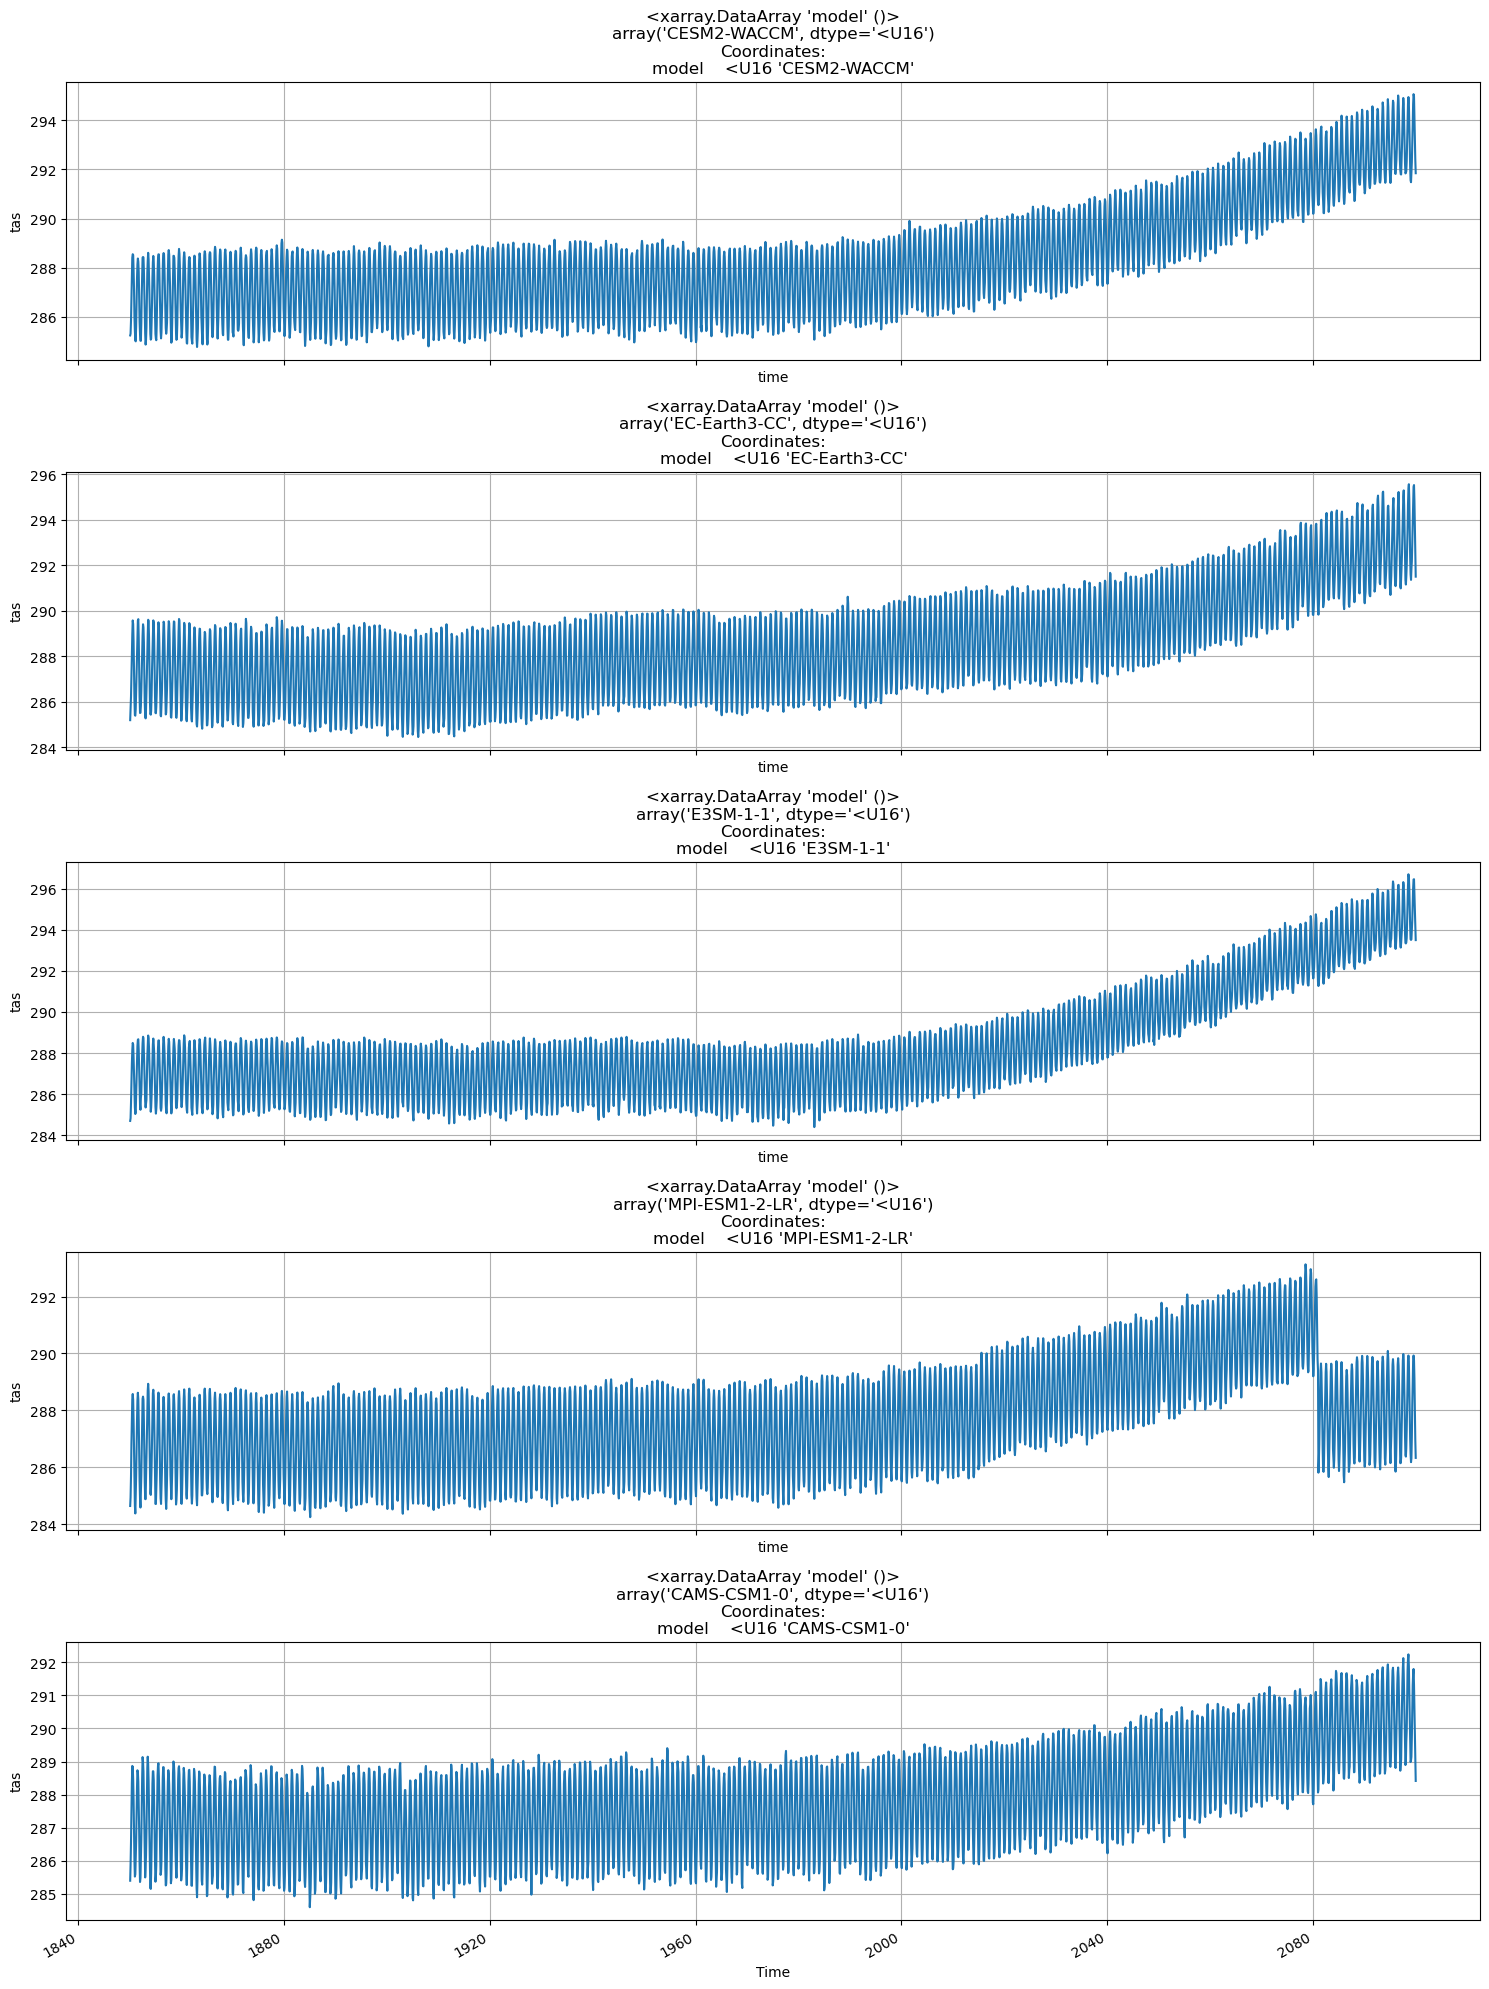

In [104]:
fig, axs = plt.subplots(5, 1, figsize=(15, 20), sharex=True)
fig_counter_5 = 20
while fig_counter_5 < 25: #made another while loop to separate the graphs and make it cleaner
    for i, model in enumerate(ds_all_models.model[20:]): #sliced from 20th index after last model figure shown in previous cell block (index should be same each time in dataset)
        if fig_counter_5 >= 25:
            break
        ds_all_models.sel(model=model).tas.plot(ax=axs[i], label=model) #selects each model and the tas variable, plots over each axes
        axs[i].set_title(model) #shows what model number
        axs[i].set_ylabel('tas')
        axs[i].grid(True) #makes gridlines on plot
        fig_counter_5 +=1
axs[-1].set_xlabel('Time') 
plt.tight_layout() #creates a better layout for subplots
plt.show()

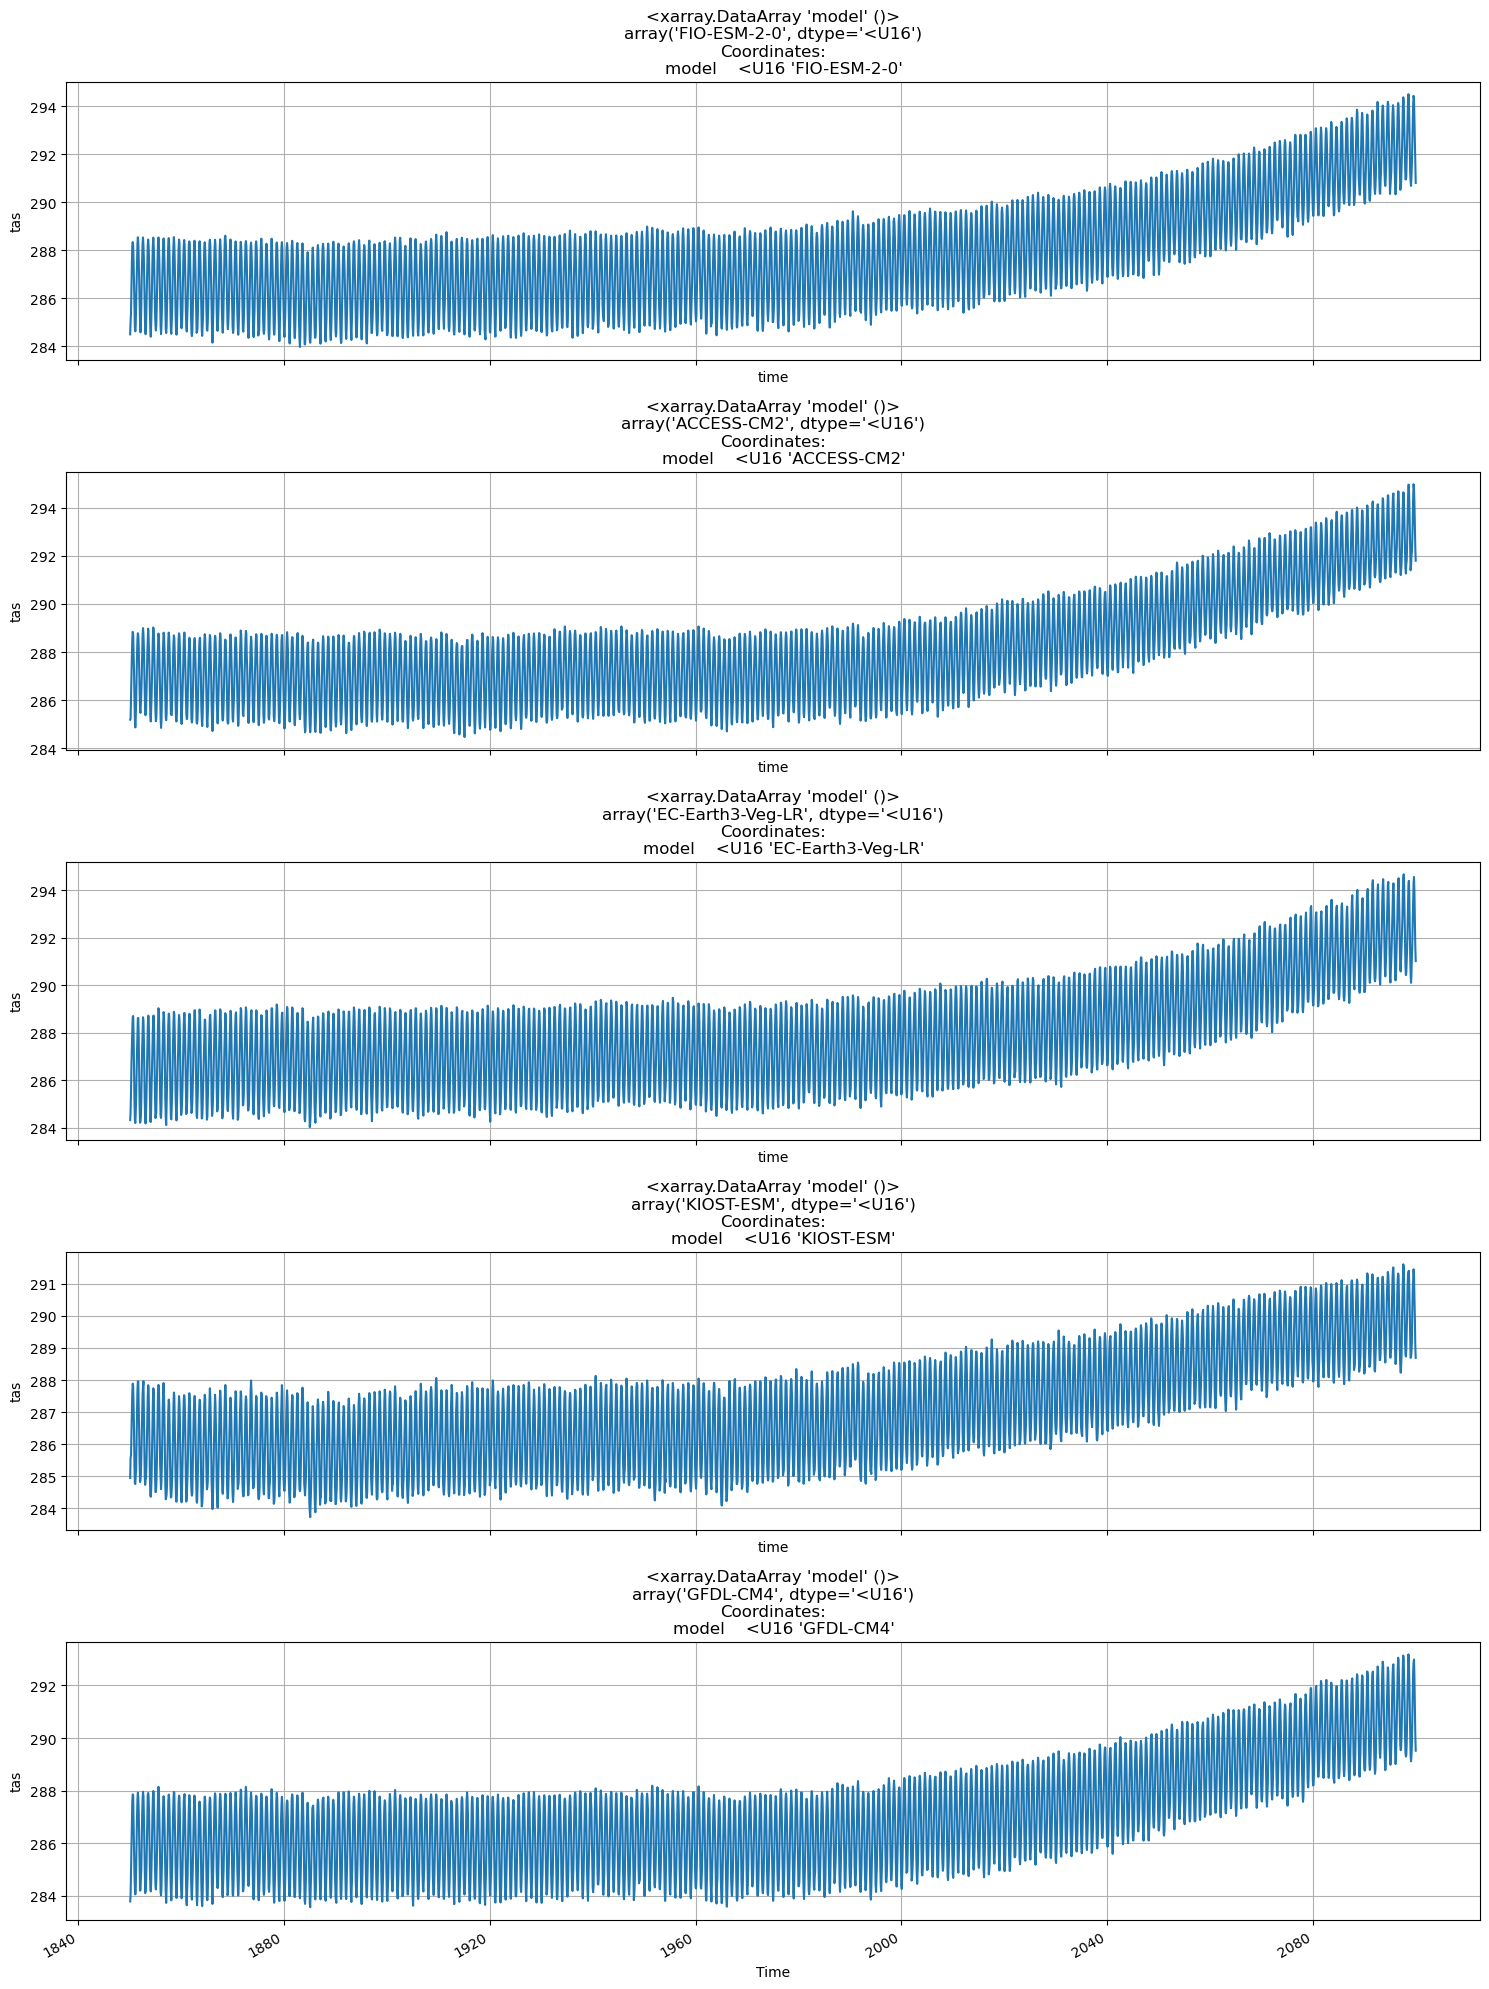

In [106]:
fig, axs = plt.subplots(5, 1, figsize=(15, 20), sharex=True)
fig_counter_6 = 25
while fig_counter_6 < 30: #made another while loop to separate the graphs and make it cleaner
    for i, model in enumerate(ds_all_models.model[25:]): #sliced from 25th index after last model figure shown in previous cell block (index should be same each time in dataset)
        if fig_counter_6 >= 30:
            break
        ds_all_models.sel(model=model).tas.plot(ax=axs[i], label=model) #selects each model and the tas variable, plots over each axes
        axs[i].set_title(model) #shows what model number
        axs[i].set_ylabel('tas')
        axs[i].grid(True) #makes gridlines on plot
        fig_counter_6 +=1
axs[-1].set_xlabel('Time') 
plt.tight_layout() #creates a better layout for subplots
plt.show()

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(15, 20), sharex=True)
fig_counter_7 = 30
while fig_counter_2 < 34: #made another while loop to separate the graphs and make it cleaner
    for i, model in enumerate(ds_all_models.model[30:]): #sliced from 30th index after last model figure shown in previous cell block (index should be same each time in dataset)
        if fig_counter_7 >= 34:
            break
        ds_all_models.sel(model=model).tas.plot(ax=axs[i], label=model) #selects each model and the tas variable, plots over each axes
        axs[i].set_title(model) #shows what model number
        axs[i].set_ylabel('tas')
        axs[i].grid(True) #makes gridlines on plot
        fig_counter_7 +=1
axs[-1].set_xlabel('Time') 
plt.tight_layout() #creates a better layout for subplots
plt.show()

In [ ]:
#general fn for makes these 5 by 1 subplots
def plot_time_series5(fig_counter_input, model_index):
    fig, axs = plt.subplots(5, 1, figsize=(15, 20), sharex=True)
    fig_counter = fig_counter_input
    while fig_counter < (fig_counter_input + 5): #made another while loop to separate the graphs and make it cleaner
        for i, model in enumerate(ds_all_models.model[model_index:]): #sliced from 30th index after last model figure shown in previous cell block (index should be same each time in dataset)
            if fig_counter >= (fig_counter_input + 5):
                break
            ds_all_models.sel(model=model).tas.plot(ax=axs[i], label=model) #selects each model and the tas variable, plots over each axes
            axs[i].set_title(model) #shows what model number
            axs[i].set_ylabel('tas')
            axs[i].grid(True) #makes gridlines on plot
            fig_counter +=1
    axs[-1].set_xlabel('Time') 
    plt.tight_layout() #creates a better layout for subplots
    plt.show()